In [30]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import ephem
import cmocean
import datetime
import numpy as np
import seaborn as sns
from scipy import signal
from IPython import display
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm, DivergingNorm, SymLogNorm, Normalize

sns.set()
sns.set_style("ticks")

In [3]:
from spectral_analysis.common_vars.time_slices import idx_t
from spectral_analysis.common_vars.directories import LUIGI_OUT_FOLDER,POSTPROCESS_OUT_FOLDER
from spectral_analysis.common_vars.regions import ids_regions,lats4id,lons4id,faces_regions
from spectral_analysis.isotropic_spectra.spectral_kinema import spectral_kinematics
from spectral_analysis.isotropic_spectra.isotropic import calc_ispec
from spectral_analysis.luigi_workflows.llc_region import LLCRegion
from spectral_analysis.luigi_workflows.output import theta4idt,Theta4id,uv4idt,UV4id,heatFlux4idt,HF4id,hbl4idt,KPPhbl4id,VorticityGrid,Tau4id,tau4idt

In [4]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [5]:
spectra_folder= POSTPROCESS_OUT_FOLDER+"/wk_spectra"
spectra_fn_fmt = "{folder}/{id}_{season}_{t_res}.npz"

def spectra_exists(rid,season,t_res="hours"):
    spectra_fn = spectra_fn_fmt.format(folder=spectra_folder, id=rid, season=season, t_res=t_res)
    logging.debug("{}: {} -- Filename {}".format(rid,season,spectra_fn))
    return os.path.exists(spectra_fn)

def save_spectra(spec,rid,season,t_res="hours"):
    spectra_fn = spectra_fn_fmt.format(folder=spectra_folder, id=rid, season=season, t_res=t_res)
    logging.debug("{}: {} -- Filename {}".format(rid,season,spectra_fn))
    ensure_dir(spectra_fn)
    np.savez_compressed(spectra_fn,**spec)
    spec_vars = [k for k in spec.keys()]
    logging.info("Saved spectra {}".format(spectra_fn))
    logging.info("Variables: {}".format(spec_vars))
    
def load_spectra(rid,season,t_res="hours"):
    spectra_fn = spectra_fn_fmt.format(folder=spectra_folder, id=rid, season=season, t_res=t_res)
    logging.debug("{}: {} -- Opening {}".format(rid,season,spectra_fn))
    return np.load(spectra_fn)

def ensure_spectra(rid,season,t_res="hours"):
    if spectra_exists(rid,season,t_res=t_res):
        logging.info("Spectra file exists. Skipping.")
    else:
        spectra_tmp = {}
        logging.info("File not found. Calculating...")
        utest,vtest = UV4id(rid,idx_t[t_res][season],0)
        KE,RV,DIV,k,l,om = spectral_kinematics(utest,vtest,2,2,1)
        ki,KEi = calc_ispec(KE,k,l,om)
        ki,RVi = calc_ispec(RV,k,l,om)
        ki,DIVi = calc_ispec(DIV,k,l,om)
        spectra_tmp["om"] = om
        spectra_tmp["k_h"] = ki
        spectra_tmp["KE"] = KEi
        spectra_tmp["KE_RV"] = RVi
        spectra_tmp["KE_DIV"] = DIVi

        ## Integral in frequency domain
        dom = om[1]-om[0]
        spectra_tmp["KE_k"] = KEi.sum(axis=1)*dom
        spectra_tmp["RV_k"] = RVi.sum(axis=1)*dom
        spectra_tmp["DIV_k"] = DIVi.sum(axis=1)*dom

        # Save
        save_spectra(spectra_tmp,rid,season,t_res=t_res)

In [6]:
import logging
logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.DEBUG,
    datefmt="%Y-%m-%d %H:%M:%S")

#logging.getLogger("matplotlib.font_manager").setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True

## RV y DIV en marzo y octubre 2012

In [7]:
divnorm_deltaro = DivergingNorm(vmin=-1, vcenter=0, vmax=1)

def plot_rvdiv_seasons(current):
  #rid = ids_regions[current][-2]
  for rid in ids_regions[current]:
    print(current,ids_regions[current],rid)
    grid = VorticityGrid(rid)
    # JFM
    idx_tjfm = -11
    idx_t_jfm = idx_t["hours"]["JFM"][idx_tjfm]
    print(idx_tjfm,idx_t_jfm)
    ujfm,vjfm = uv4idt(rid,idx_t_jfm,0)
    logging.info("Sizes U,V [MB]: {},{}".format(ujfm.nbytes/(1024**2),vjfm.nbytes/(1024**2)))
    logging.info("dtypes U,V: {},{}".format(ujfm.dtype,vjfm.dtype))
    ro_jfm = grid.rv(ujfm,vjfm)/grid.f
    delta_jfm = grid.div(ujfm,vjfm)/grid.f
    # ASO
    idx_taso = -6
    idx_t_aso = idx_t["hours"]["ASO"][idx_taso]
    uaso,vaso = uv4idt(rid,idx_t_aso,0)
    logging.info("Sizes U,V [MB]: {},{}".format(uaso.nbytes/(1024**2),vaso.nbytes/(1024**2)))
    logging.info("dtypes U,V: {},{}".format(uaso.dtype,vaso.dtype))
    ro_aso = grid.rv(uaso,vaso)/grid.f
    delta_aso = grid.div(uaso,vaso)/grid.f
    # Plot
    fig, ax = plt.subplots(3,2,figsize=(14,12))
    ax = ax.flat[:]
    plt.sca(ax[0])
    plt.pcolormesh(grid.lon_g,grid.lat_g,ro_jfm,norm=divnorm_deltaro,cmap=plt.cm.RdBu)
    plt.title("RV: JFM @ {} ({})".format(rid,current))
    plt.colorbar()
    plt.sca(ax[1])
    plt.pcolormesh(grid.lon_g,grid.lat_g,ro_aso,norm=divnorm_deltaro,cmap=plt.cm.RdBu)
    plt.title("RV: ASO @ {} ({})".format(rid,current))
    plt.colorbar()
    plt.sca(ax[2])
    plt.pcolormesh(grid.lon_c,grid.lat_c,delta_jfm,norm=divnorm_deltaro,cmap=plt.cm.RdBu)
    plt.title("DIV: JFM @ {} ({})".format(rid,current))
    plt.colorbar()
    plt.sca(ax[3])
    plt.pcolormesh(grid.lon_c,grid.lat_c,delta_aso,norm=divnorm_deltaro,cmap=plt.cm.RdBu)
    plt.title("DIV: ASO @ {} ({})".format(rid,current))
    plt.colorbar()
    # Joint PDF
    min_ro = min(np.min(ro_jfm),np.min(ro_aso))
    #min_ro = np.min(ro_jfm)
    max_ro = max(np.max(ro_jfm),np.max(ro_aso))
    #max_ro = np.max(ro_jfm)
    min_delta = min(np.min(delta_jfm),np.min(delta_aso))
    #min_delta = np.min(delta_jfm)
    max_delta = max(np.max(delta_jfm),np.max(delta_aso))
    #max_delta = np.max(delta_jfm)
    rolim = [min_ro,max_ro]
    deltalim = [min_delta,max_delta]
    plt.sca(ax[4])
    plt.hist2d(ro_jfm.flat[:],delta_jfm.flat[:],bins=100,density=True,norm=LogNorm(),cmap=plt.cm.cubehelix_r)
    plt.xlim(rolim)
    plt.ylim(deltalim)
    plt.xlabel("$RV/f$")
    plt.ylabel("$DIV/f$")
    plt.colorbar()
    plt.title("RV-DIV: JFM @ {} ({})".format(rid,current))
    plt.sca(ax[5])
    plt.hist2d(ro_aso.flat[:],delta_aso.flat[:],bins=100,density=True,norm=LogNorm(),cmap=plt.cm.cubehelix_r)
    plt.xlim(rolim)
    plt.ylim(deltalim)
    plt.xlabel("$RV/f$")
    plt.ylabel("$DIV/f$")
    plt.colorbar()
    plt.title("RV-DIV: ASO @ {} ({})".format(rid,current))
    plt.show()

California [762] 762
-11 4813


2021-04-04 08:28:24 INFO     Sizes U,V [MB]: 0.3175048828125,0.3175048828125
2021-04-04 08:28:24 INFO     dtypes U,V: float32,float32
2021-04-04 08:28:24 INFO     Sizes U,V [MB]: 0.3175048828125,0.3175048828125
2021-04-04 08:28:24 INFO     dtypes U,V: float32,float32


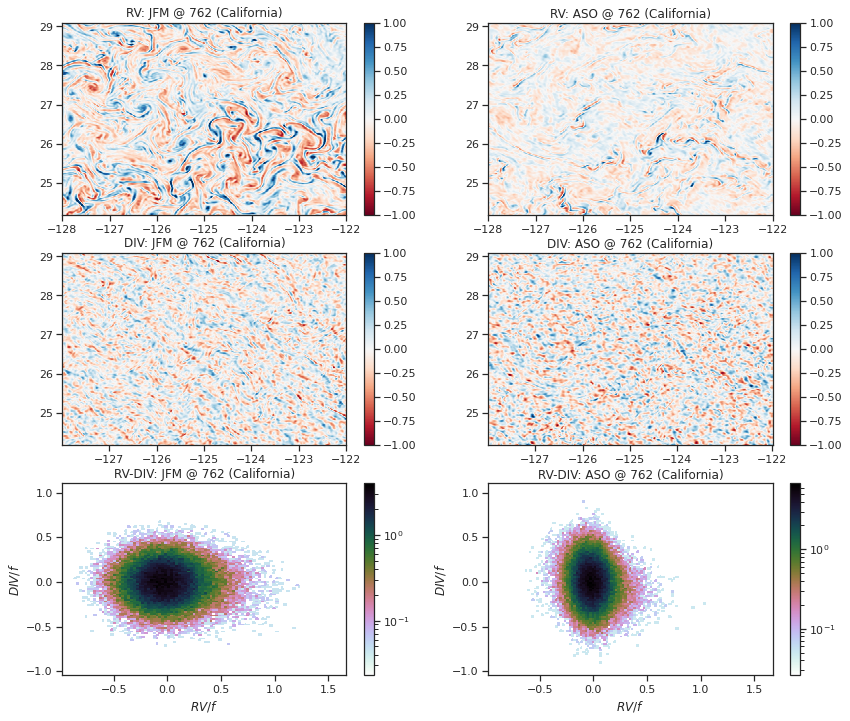

In [19]:
plot_rvdiv_seasons("California")

Canarias [750] 750


2021-04-04 08:28:32 INFO     Sizes U,V [MB]: 0.3175048828125,0.3175048828125
2021-04-04 08:28:32 INFO     dtypes U,V: float32,float32


-11 4813


2021-04-04 08:28:32 INFO     Sizes U,V [MB]: 0.3175048828125,0.3175048828125
2021-04-04 08:28:32 INFO     dtypes U,V: float32,float32


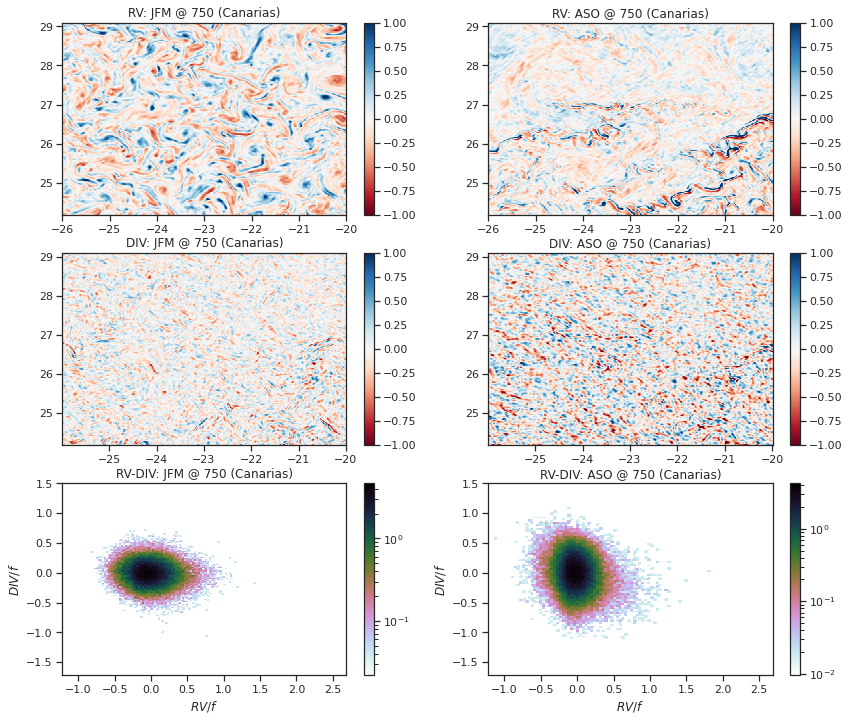

In [20]:
plot_rvdiv_seasons("Canarias")

Peru [450, 572] 450
-11 4813


2021-04-04 08:28:42 INFO     Sizes U,V [MB]: 0.31970977783203125,0.31970977783203125
2021-04-04 08:28:42 INFO     dtypes U,V: float32,float32
2021-04-04 08:28:42 INFO     Sizes U,V [MB]: 0.31970977783203125,0.31970977783203125
2021-04-04 08:28:42 INFO     dtypes U,V: float32,float32


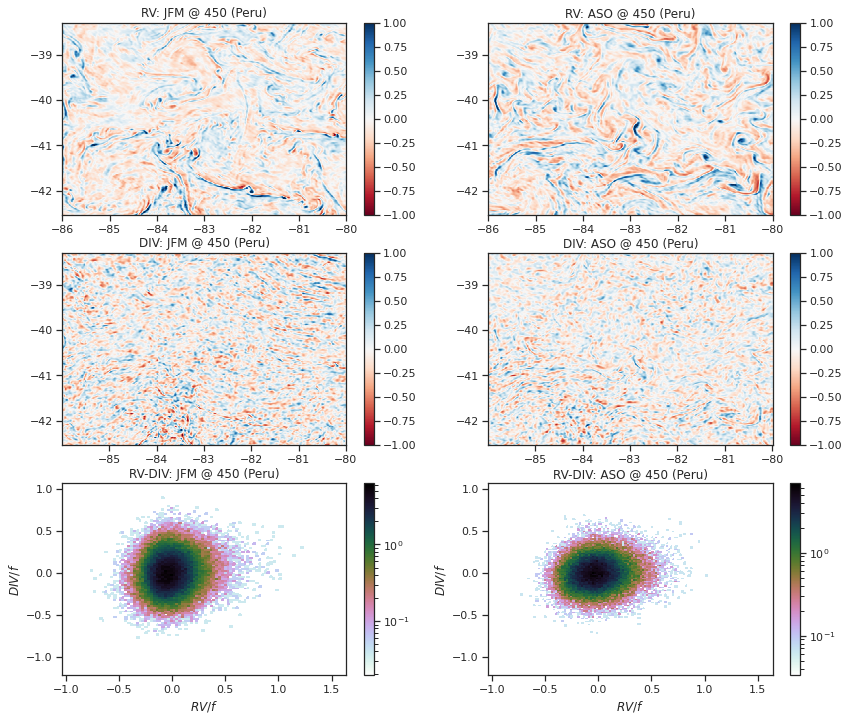

Peru [450, 572] 572
-11 4813


2021-04-04 08:28:45 INFO     Sizes U,V [MB]: 0.31970977783203125,0.31970977783203125
2021-04-04 08:28:45 INFO     dtypes U,V: float32,float32
2021-04-04 08:28:45 INFO     Sizes U,V [MB]: 0.31970977783203125,0.31970977783203125
2021-04-04 08:28:45 INFO     dtypes U,V: float32,float32


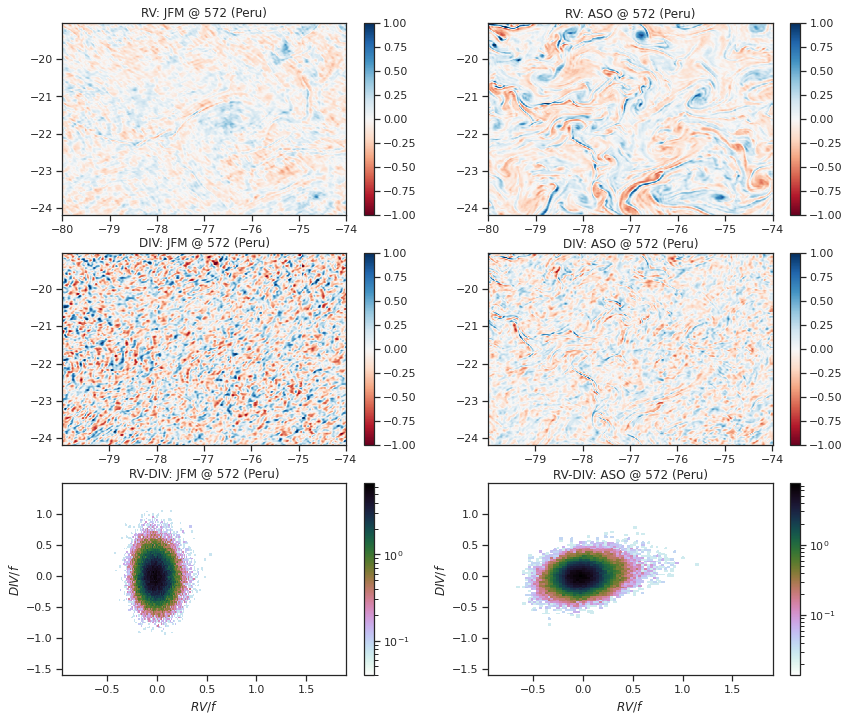

In [21]:
plot_rvdiv_seasons("Peru")

Benguela [533] 533
-11 4813


2021-04-04 08:28:55 INFO     Sizes U,V [MB]: 0.3175048828125,0.3175048828125
2021-04-04 08:28:55 INFO     dtypes U,V: float32,float32
2021-04-04 08:28:56 INFO     Sizes U,V [MB]: 0.3175048828125,0.3175048828125
2021-04-04 08:28:56 INFO     dtypes U,V: float32,float32


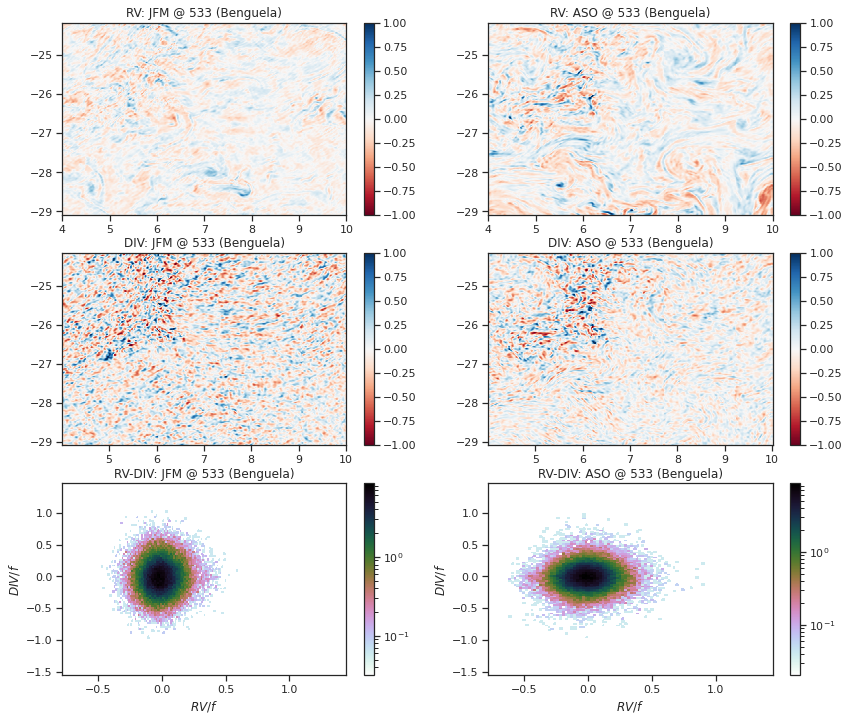

In [22]:
plot_rvdiv_seasons("Benguela")

## $\omega$-k de la parte rotacional y divergente de KE

In [8]:
logging.getLogger().setLevel(logging.INFO)

In [9]:
cmap_ranges = {
    "KE": [1e-5,1e-2],
    "RV": [1e-12,1e-10],
    "DIV": [1e-12,1e-10],
    "RVDIV": [0.1,10]
}

In [10]:
from shapely.geometry import LineString

In [11]:
def intersection(pa1,pa2,pb1,pb2):
    lineA = LineString([pa1,pa2])
    lineB = LineString([pb1,pb2])
    intersection = lineA.intersection(lineB)
    return intersection.x,intersection.y

In [12]:
def ab_intersection(A,B,x=None):
    if x is None:
        x = [x for x in range(len(A))]
    diff = A-B
    sign = np.sign(diff)
    sign_change = (np.roll(sign,1)-sign) != 0
    sign_change[0] = False
    #print(sign_change)
    #print(len(diff))
    num_int = 0
    ints = []
    for i,ch in enumerate(sign_change[1:]):
        #print(i,ch,x[i],diff[i],x[i+1],diff[i+1])
        if(ch):
            num_int += 1
            int_x,int_y = intersection((x[i],A[i]),(x[i+1],A[i+1]),(x[i],B[i]),(x[i+1],B[i+1]))
            #print("\t\t",int_x,int_y)
            #plt.plot(int_x,int_y,'X',label='int {}'.format(num_int))
            ints.append((int_x,int_y))
    if num_int==0:
        min_idx = np.argmin(np.abs(diff))
        int_x,int_y = x[min_idx],diff[min_idx]
        #plt.axvline(x=int_x,label='* int ')
        ints.append((int_x,int_y))
    return diff,ints

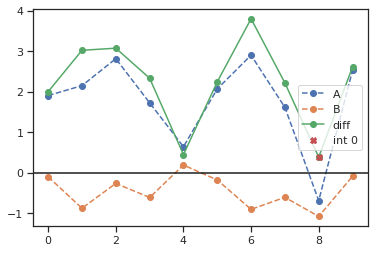

In [13]:
## Testing ab_intersection with random data
a = np.random.randn(10)+2
b = np.random.randn(10)
plt.figure()
plt.plot(a,'--o',label='A')
plt.plot(b,'--o',label='B')
diff,ints = ab_intersection(a,b)
plt.plot(diff,'-o',label='diff')
for intx,inty in ints:
    plt.plot(intx,inty,'X',label='int {}'.format(0))
plt.legend()
plt.axhline(y=0,color='k')
plt.show()

In [14]:
def wk_spec(current):
    for rid in ids_regions[current]:
        for season in ["ASO","JFM"]:
            ensure_spectra(rid,season)

In [15]:
%matplotlib inline
xlims = [1/150,1/8]
xticks = [1/10,1/25,1/50,1/80,1/150]
xticksLabel = ['10','25','50','80','150']
yticks = [1/3,1/6,1/12,1/24,1/(24*7),1/(24*30)]
yticksLabel = ['3 h','6 h','12 h','1 d','1 w','1 mo']
# Lt plots
xticks_ = [1/10,1/20,1/30,1/40,1/50,1/75,1/100,1/150]
xticksLabel_ = ['10','20','30','40','50','75','100','150']

def plot_spectra(current):
    for rid in ids_regions[current]:
        for season in ["ASO","JFM"]:
            logging.info("{} ({}): {}".format(rid,current,season))
            # Loading
            ensure_spectra(rid,season)
            spectra_tmp = load_spectra(rid,season)
            om = spectra_tmp["om"]
            ki = spectra_tmp["k_h"][2:] if rid==572 else spectra_tmp["k_h"][1:]
            KEi = spectra_tmp["KE"][1:,:] if rid==730 else spectra_tmp["KE"]
            RVi = spectra_tmp["KE_RV"][1:,:] if rid==730 else spectra_tmp["KE_RV"]
            DIVi = spectra_tmp["KE_DIV"][1:,:] if rid==730 else spectra_tmp["KE_DIV"]
            logging.info("Shapes iso: om {}, ki {}, KE {}, RV {}, DIV {}".format(om.shape, ki.shape, KEi.shape, RVi.shape, DIVi.shape))
            fig, ax = plt.subplots(1,4,figsize=(20,4))
            ax = ax.flat[:]
            ## KE
            plt.sca(ax[0])
            plt.pcolormesh(ki,om,(om*KEi).T*ki,norm = colors.LogNorm(),cmap='nipy_spectral_r')
            plt.clim(cmap_ranges["KE"])
            plt.xscale('log')
            plt.xticks(xticks,xticksLabel)
            #plt.xlim([ki[1],ki[-1]/2.5])
            plt.xlim(xlims)
            plt.yscale('log')
            plt.ylim([om[1],om[-100]])
            plt.yticks(yticks,yticksLabel)
            plt.colorbar()
            plt.title("KE: "+season)
            ## RV
            plt.sca(ax[1])
            plt.pcolormesh(ki,om,(om*RVi).T*ki,norm = colors.LogNorm(),cmap='nipy_spectral_r')
            plt.clim(cmap_ranges["KE"])
            plt.xscale('log')
            plt.xticks(xticks,xticksLabel)
            #plt.xlim([ki[1],ki[-1]/2.5])
            plt.xlim(xlims)
            plt.yscale('log')
            plt.ylim([om[1],om[-100]])
            plt.yticks(yticks,yticksLabel)
            plt.colorbar()
            plt.title("$KE_{RV}$: "+season)
            ## DIV
            plt.sca(ax[2])
            plt.pcolormesh(ki,om,(om*DIVi).T*ki,norm = colors.LogNorm(),cmap='nipy_spectral_r')
            plt.clim(cmap_ranges["KE"])
            plt.xscale('log')
            plt.xticks(xticks,xticksLabel)
            #plt.xlim([ki[1],ki[-1]/2.5])
            plt.xlim(xlims)
            plt.yscale('log')
            plt.ylim([om[1],om[-100]])
            plt.yticks(yticks,yticksLabel)
            plt.colorbar()
            plt.title("$KE_{DIV}$: "+season)
            ## RV/DIV
            plt.sca(ax[3])
            RVDIV = RVi/DIVi
            minRVDIV = np.log10(np.min(RVDIV))
            maxRVDIV = np.log10(np.max(RVDIV))
            limExp = min(np.abs(minRVDIV),maxRVDIV)
            lims = (10**(-limExp),10**limExp)
            plt.pcolormesh(ki,om,(RVDIV).T,norm = colors.LogNorm(vmin=lims[0],vmax=lims[1],clip=True),cmap=plt.cm.BrBG)
            #plt.clim(cmap_ranges["RVDIV"])
            plt.xscale('log')
            plt.xticks(xticks,xticksLabel)
            #plt.xlim([ki[1],ki[-1]/2.5])
            plt.xlim(xlims)
            plt.yscale('log')
            plt.ylim([om[1],om[-100]])
            plt.yticks(yticks,yticksLabel)
            plt.colorbar()
            plt.title("$RV/DIV$: "+season)
            ## Show
            plt.show()
            plt.close()

        # See https://stackoverflow.com/questions/34486642/what-is-the-currently-correct-way-to-dynamically-update-plots-in-jupyter-ipython
        with sns.axes_style("whitegrid"):
            fig, ax = plt.subplots(1,2,figsize=(15,5))
            ax = ax.flat[:]
            for i,season in enumerate(["ASO","JFM"]):
                # Loading
                spectra_tmp = load_spectra(rid,season)
                # Plotting
                plt.sca(ax[i])
                ki = spectra_tmp["k_h"][2:] if rid==572 else spectra_tmp["k_h"][1:]
                KEk = spectra_tmp["KE_k"][1:] if rid==730 else spectra_tmp["KE_k"]
                RVk = spectra_tmp["RV_k"][1:] if rid==730 else spectra_tmp["RV_k"]
                DIVk = spectra_tmp["DIV_k"][1:] if rid==730 else spectra_tmp["DIV_k"]
                logging.info("Shapes k_h: ki {}, KE {}, RV {}, DIV {}".format(ki.shape, KEk.shape, RVk.shape, DIVk.shape))
                plt.loglog(ki,KEk,'--',label='$KE$')
                plt.loglog(ki,RVk,label='$KE_{RV}$')
                plt.loglog(ki,DIVk,label='$KE_{DIV}$')
                _,intersects = ab_intersection(RVk,DIVk,ki)
                for intx,inty in intersects:
                    #plt.axvline(x=intx,ls='--',c='gray',alpha=0.5)
                    print("Candidate Lt ({}): {}".format(season,1/intx))
                plt.xscale('log')
                plt.yscale('log')
                plt.xticks(xticks_,xticksLabel_)
                plt.xlim(xlims)
                plt.legend(["$KE$","$KE_{RV}$","$KE_{DIV}$"], prop={'size': 'large'})
                plt.xlabel("Horizontal scale [km]",size='xx-large')
                plt.ylabel("Power spectral density [dB]",size='xx-large')
                plt.title(season)
            did = display.display(fig,display_id=True)

            for i,season in enumerate(["ASO","JFM"]):
                # Loading -- We assume all files already exist. Else, previous steps should be executed.
                spectra_tmp = dict(load_spectra(rid,season))
                # Check whether Lt exists
                try:
                    Lt = spectra_tmp["Lt_km"]
                    if Lt is None:
                        raise Exception("No Lt")
                except Exception as err:
                    Lt = float(input("Lt for {}: ".format(season)))
                    spectra_tmp["Lt_km"] = Lt
                    # We overwrite the file to include Lt as well
                    save_spectra(spectra_tmp,rid,season)
                plt.sca(ax[i])
                plt.axvline(x=1/Lt,color='r')
                plt.title("{}: Lt = {} km".format(season,Lt),size='large')
                did.update(fig)
            plt.clf()
            plt.close()

In [ ]:
for current in ["California","Canarias","Peru","Benguela"]:
    wk_spec(current)

2021-04-04 11:24:23 INFO     Spectra file exists. Skipping.
2021-04-04 11:24:23 INFO     Spectra file exists. Skipping.
2021-04-04 11:24:23 INFO     Spectra file exists. Skipping.
2021-04-04 11:24:23 INFO     Spectra file exists. Skipping.
2021-04-04 11:24:23 INFO     Spectra file exists. Skipping.
2021-04-04 11:24:23 INFO     Spectra file exists. Skipping.
2021-04-04 11:24:23 INFO     Spectra file exists. Skipping.
2021-04-04 11:24:23 INFO     Spectra file exists. Skipping.
2021-04-04 11:24:23 INFO     Spectra file exists. Skipping.
2021-04-04 11:24:23 INFO     Spectra file exists. Skipping.
2021-04-04 11:24:23 INFO     Spectra file exists. Skipping.
2021-04-04 11:24:23 INFO     Spectra file exists. Skipping.


2021-04-04 11:35:46 INFO     762 (California): ASO
2021-04-04 11:35:46 INFO     Spectra file exists. Skipping.
2021-04-04 11:35:46 INFO     Shapes iso: om (1105,), ki (143,), KE (143, 1105), RV (143, 1105), DIV (143, 1105)


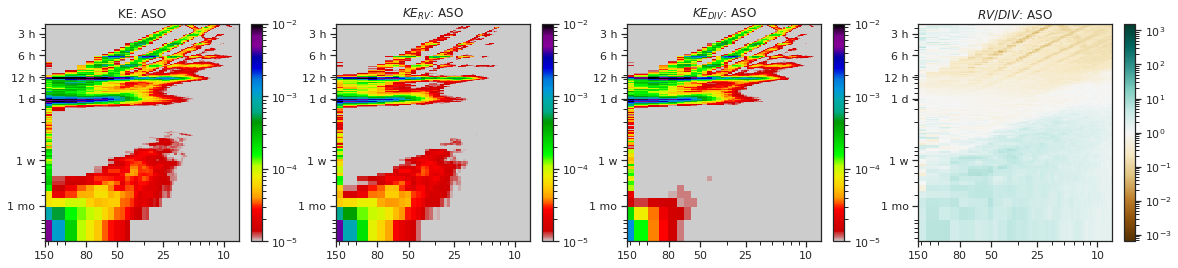

2021-04-04 11:35:49 INFO     762 (California): JFM
2021-04-04 11:35:49 INFO     Spectra file exists. Skipping.
2021-04-04 11:35:49 INFO     Shapes iso: om (1093,), ki (143,), KE (143, 1093), RV (143, 1093), DIV (143, 1093)


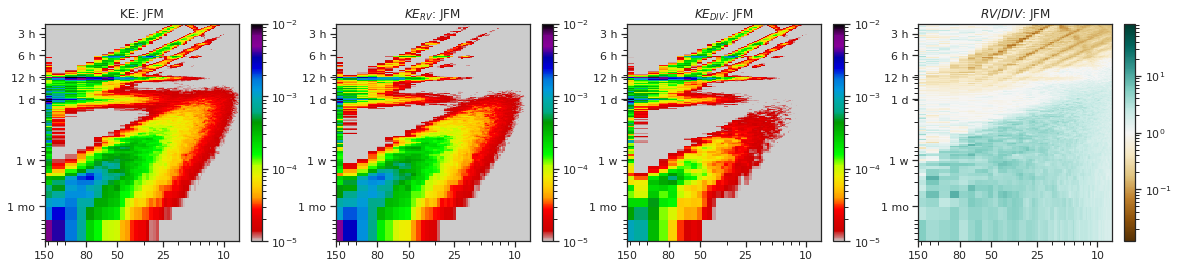

2021-04-04 11:35:51 INFO     Shapes k_h: ki (143,), KE (143,), RV (143,), DIV (143,)
2021-04-04 11:35:51 INFO     Shapes k_h: ki (143,), KE (143,), RV (143,), DIV (143,)


Candidate Lt (ASO): 183.3429812371122
Candidate Lt (ASO): 100.23712571161639
Candidate Lt (JFM): 214.3169906379958
Candidate Lt (JFM): 4.7008517279091455


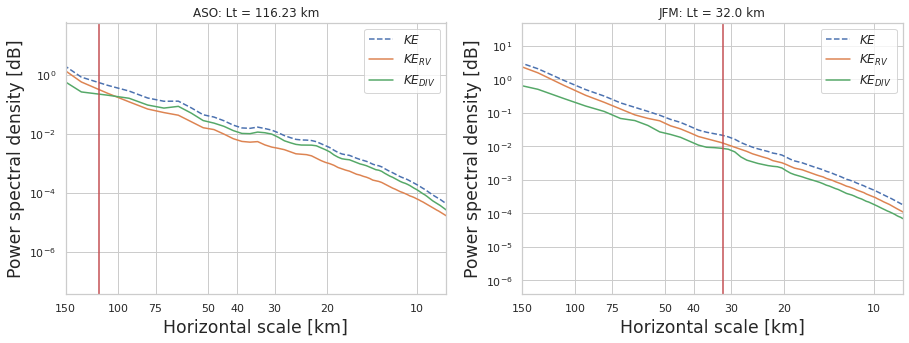

2021-04-04 11:35:56 INFO     750 (Canarias): ASO
2021-04-04 11:35:56 INFO     Spectra file exists. Skipping.
2021-04-04 11:35:56 INFO     Shapes iso: om (1105,), ki (143,), KE (143, 1105), RV (143, 1105), DIV (143, 1105)


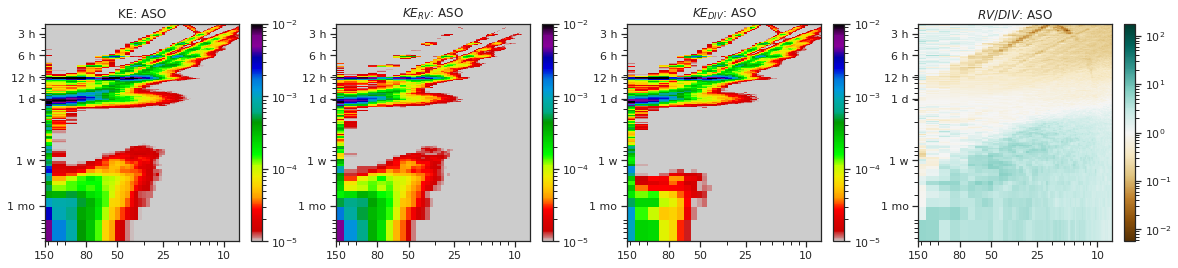

2021-04-04 11:35:59 INFO     750 (Canarias): JFM
2021-04-04 11:35:59 INFO     Spectra file exists. Skipping.
2021-04-04 11:35:59 INFO     Shapes iso: om (1093,), ki (143,), KE (143, 1093), RV (143, 1093), DIV (143, 1093)


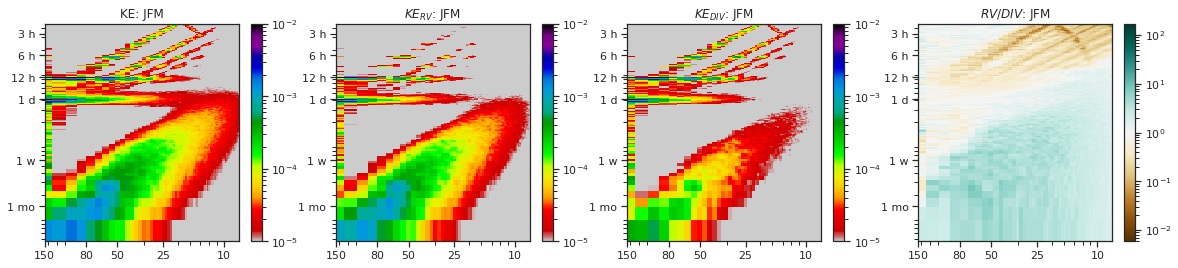

2021-04-04 11:36:01 INFO     Shapes k_h: ki (143,), KE (143,), RV (143,), DIV (143,)
2021-04-04 11:36:01 INFO     Shapes k_h: ki (143,), KE (143,), RV (143,), DIV (143,)


Candidate Lt (ASO): 245.78545418779768
Candidate Lt (ASO): 67.38249774527976
Candidate Lt (JFM): 178.56160202899588
Candidate Lt (JFM): 5.116732981312526
Candidate Lt (JFM): 5.105297124297162
Candidate Lt (JFM): 5.011858825355359


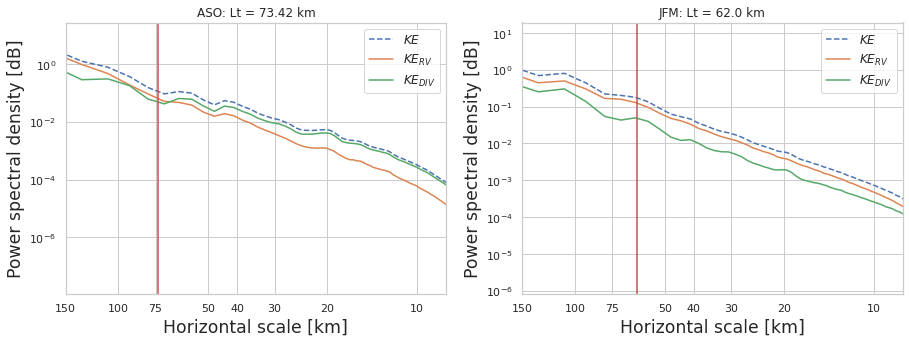

2021-04-04 11:36:06 INFO     730 (Canarias): ASO
2021-04-04 11:36:06 INFO     Spectra file exists. Skipping.
2021-04-04 11:36:06 INFO     Shapes iso: om (1105,), ki (142,), KE (142, 1105), RV (142, 1105), DIV (142, 1105)


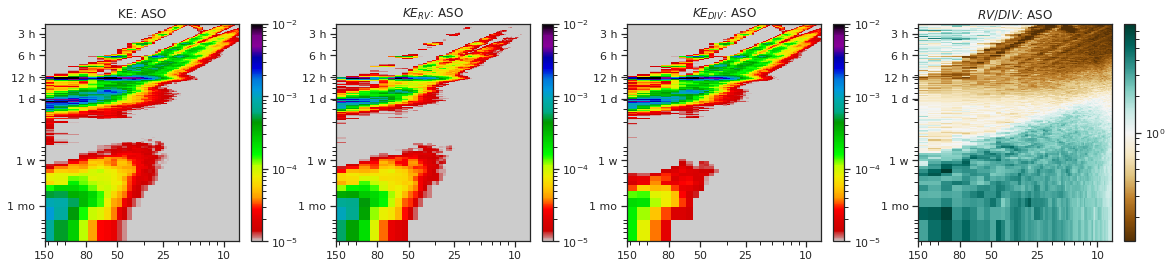

2021-04-04 11:36:08 INFO     730 (Canarias): JFM
2021-04-04 11:36:08 INFO     Spectra file exists. Skipping.
2021-04-04 11:36:09 INFO     Shapes iso: om (1093,), ki (142,), KE (142, 1093), RV (142, 1093), DIV (142, 1093)


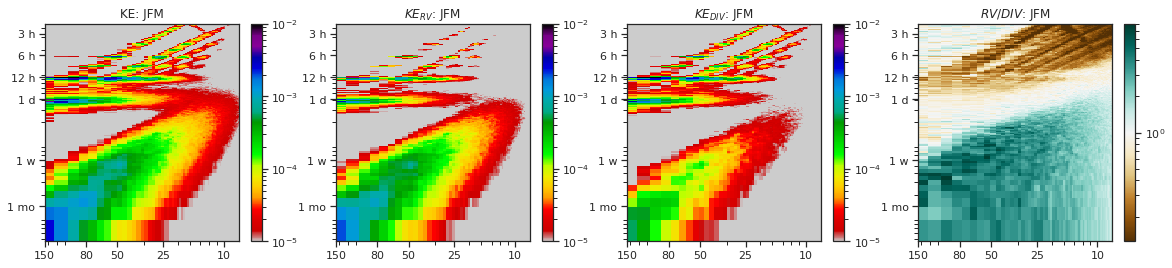

2021-04-04 11:36:11 INFO     Shapes k_h: ki (142,), KE (142,), RV (142,), DIV (142,)
2021-04-04 11:36:11 INFO     Shapes k_h: ki (142,), KE (142,), RV (142,), DIV (142,)


Candidate Lt (ASO): 261.99684036229684
Candidate Lt (ASO): 122.66612960829927
Candidate Lt (JFM): 248.33542681216505
Candidate Lt (JFM): 5.947648294250063
Candidate Lt (JFM): 5.887883022806699
Candidate Lt (JFM): 5.863555909064488


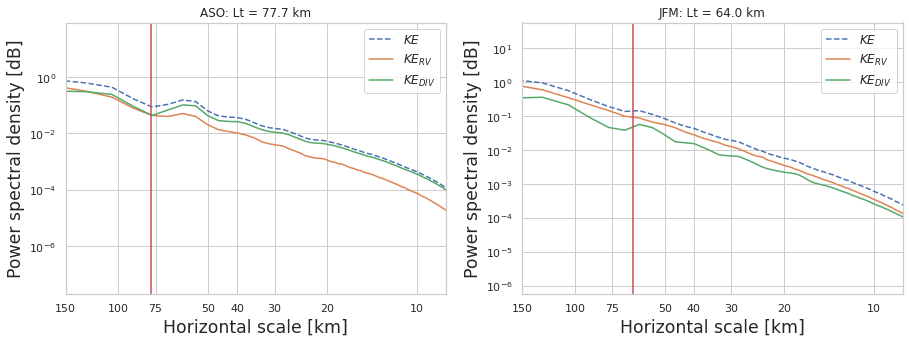

2021-04-04 11:37:10 INFO     Saved spectra /mnt/disks/LLC4320/Postprocess/wk_spectra/730_ASO_hours.npz
2021-04-04 11:37:10 INFO     Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km']
2021-04-04 11:37:25 INFO     Saved spectra /mnt/disks/LLC4320/Postprocess/wk_spectra/730_JFM_hours.npz
2021-04-04 11:37:25 INFO     Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km']
2021-04-04 11:37:26 INFO     450 (Peru): ASO
2021-04-04 11:37:26 INFO     Spectra file exists. Skipping.
2021-04-04 11:37:27 INFO     Shapes iso: om (1105,), ki (143,), KE (143, 1105), RV (143, 1105), DIV (143, 1105)


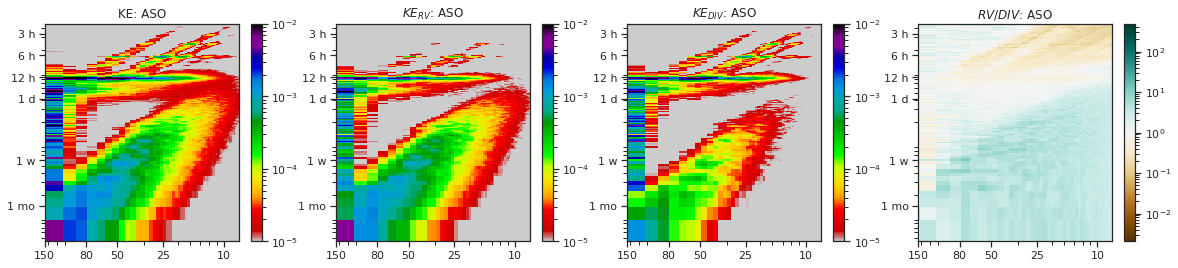

2021-04-04 11:37:29 INFO     450 (Peru): JFM
2021-04-04 11:37:29 INFO     Spectra file exists. Skipping.
2021-04-04 11:37:30 INFO     Shapes iso: om (1093,), ki (143,), KE (143, 1093), RV (143, 1093), DIV (143, 1093)


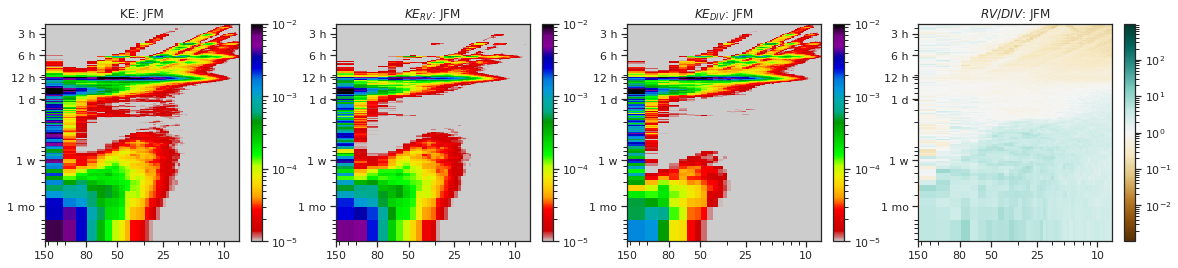

2021-04-04 11:37:32 INFO     Shapes k_h: ki (143,), KE (143,), RV (143,), DIV (143,)
2021-04-04 11:37:32 INFO     Shapes k_h: ki (143,), KE (143,), RV (143,), DIV (143,)


Candidate Lt (ASO): 186.5500608409451
Candidate Lt (JFM): 206.04145757284414
Candidate Lt (JFM): 52.36893444122295
Candidate Lt (JFM): 40.83645326066923
Candidate Lt (JFM): 40.641512768279064


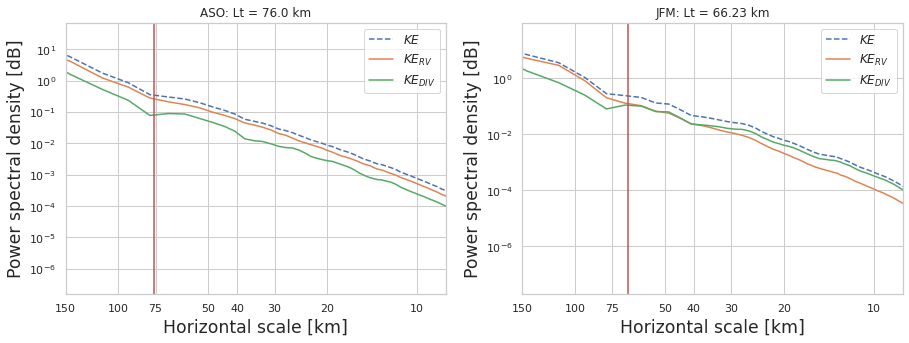

2021-04-04 11:37:37 INFO     572 (Peru): ASO
2021-04-04 11:37:37 INFO     Spectra file exists. Skipping.
2021-04-04 11:37:38 INFO     Shapes iso: om (1105,), ki (143,), KE (143, 1105), RV (143, 1105), DIV (143, 1105)


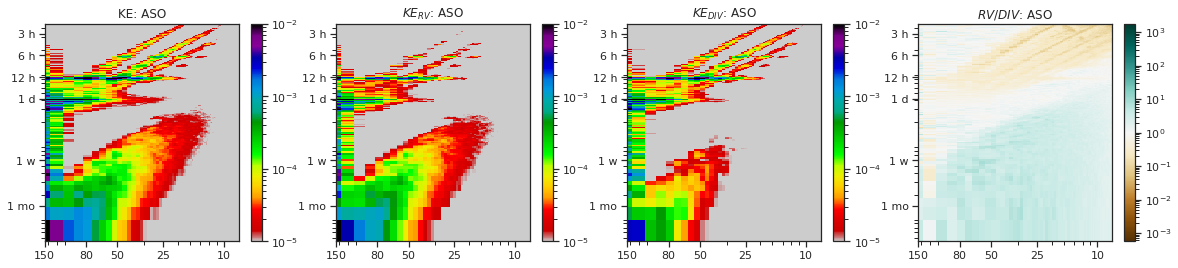

2021-04-04 11:37:40 INFO     572 (Peru): JFM
2021-04-04 11:37:40 INFO     Spectra file exists. Skipping.
2021-04-04 11:37:41 INFO     Shapes iso: om (1093,), ki (143,), KE (143, 1093), RV (143, 1093), DIV (143, 1093)


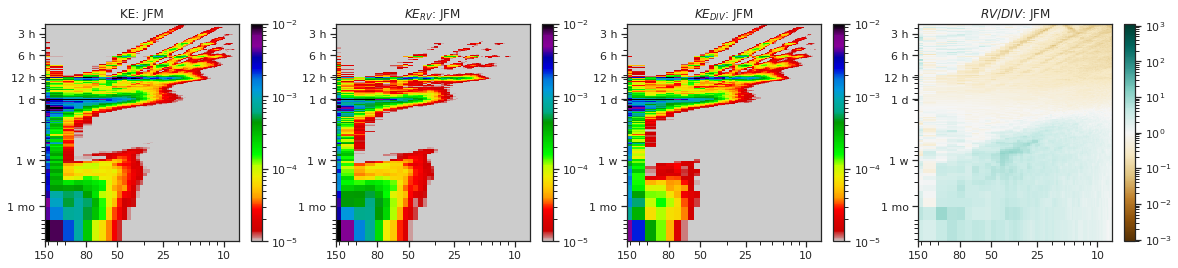

2021-04-04 11:37:43 INFO     Shapes k_h: ki (143,), KE (143,), RV (143,), DIV (143,)
2021-04-04 11:37:43 INFO     Shapes k_h: ki (143,), KE (143,), RV (143,), DIV (143,)


Candidate Lt (ASO): 138.5183080105202
Candidate Lt (ASO): 133.59789169307223
Candidate Lt (ASO): 54.851701368329174
Candidate Lt (ASO): 46.242817526009766
Candidate Lt (ASO): 38.08516537850966
Candidate Lt (ASO): 35.22551761555944
Candidate Lt (ASO): 26.644760157086683
Candidate Lt (ASO): 26.457288288356473
Candidate Lt (ASO): 6.322914372129579
Candidate Lt (JFM): 75.27073586523547
Candidate Lt (JFM): 67.70723980722738
Candidate Lt (JFM): 63.601161804460425


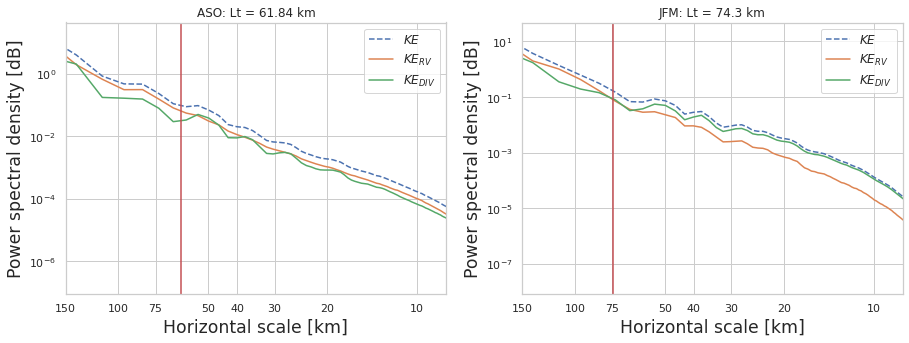

2021-04-04 11:37:48 INFO     533 (Benguela): ASO
2021-04-04 11:37:48 INFO     Spectra file exists. Skipping.
2021-04-04 11:37:48 INFO     Shapes iso: om (1105,), ki (143,), KE (143, 1105), RV (143, 1105), DIV (143, 1105)


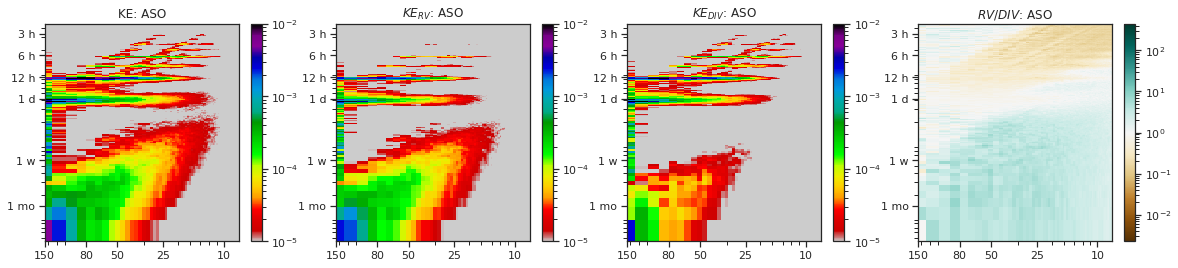

2021-04-04 11:37:51 INFO     533 (Benguela): JFM
2021-04-04 11:37:51 INFO     Spectra file exists. Skipping.
2021-04-04 11:37:51 INFO     Shapes iso: om (1093,), ki (143,), KE (143, 1093), RV (143, 1093), DIV (143, 1093)


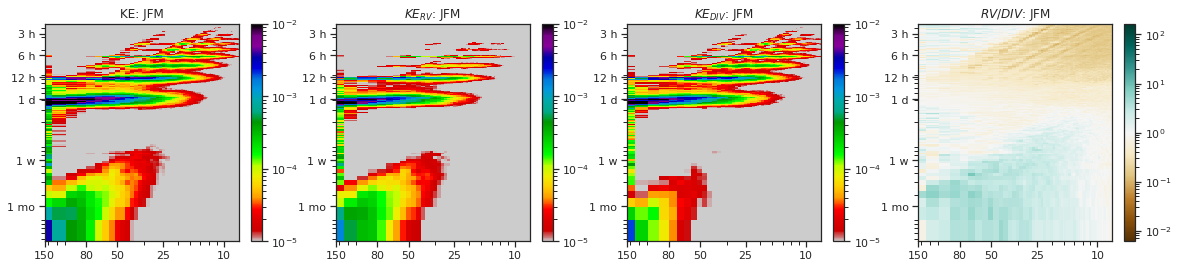

2021-04-04 11:37:54 INFO     Shapes k_h: ki (143,), KE (143,), RV (143,), DIV (143,)
2021-04-04 11:37:54 INFO     Shapes k_h: ki (143,), KE (143,), RV (143,), DIV (143,)


Candidate Lt (ASO): 174.28034926458167
Candidate Lt (ASO): 143.34519188453058
Candidate Lt (ASO): 57.330507407743994
Candidate Lt (ASO): 51.134141394259295
Candidate Lt (ASO): 5.443589656402953
Candidate Lt (JFM): 173.39010448639894
Candidate Lt (JFM): 137.93257645010144
Candidate Lt (JFM): 102.37908931400669


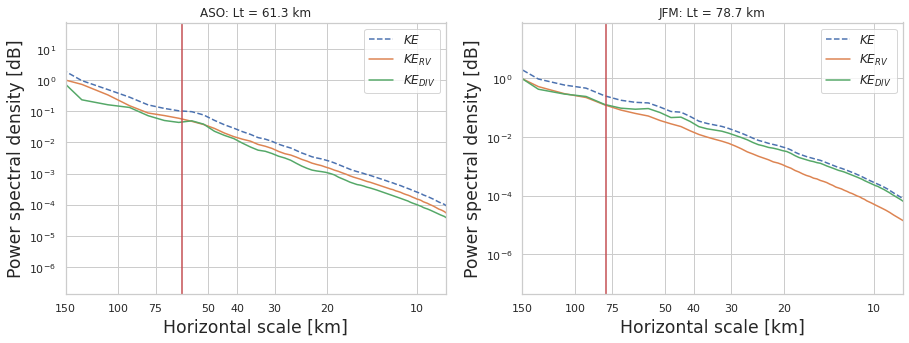

In [62]:
for current in ["California","Canarias","Peru","Benguela"]:
    plot_spectra(current)

### Calculamos RV y DIV para escalas mayores y menores a $L_t$

In [16]:
def kxky(dx,dy,shape):
    Ny,Nx = shape[-2:] # Se toman las últimas 2
    logging.info("kxky -- Nx: {}, Ny: {}".format(Nx,Ny))
    Lx = Nx*dx
    Ly = Ny*dy
    logging.info("kxky -- Lx: {}, Ly: {}".format(Lx,Ly))
    delta_kx = 1/Lx
    delta_ky = 1/Ly
    N_kx = (Nx-1)/2
    N_ky = (Ny-1)/2
    Kx = delta_kx*np.arange(-N_kx,N_kx+1)
    Ky = delta_ky*np.arange(-N_ky,N_ky+1)
    return np.meshgrid(Kx,Ky)

def create_filter_k(Lt_km=50,order=0,k_=None,flip=False): #Orden 0 es el filtro ideal, de 1 de adelante es el Butterworth
    K_max = 1/Lt_km
    kx_,ky_ = k_

    if order==0:
        filter_mask_plt = (np.square(kx_)+np.square(ky_) <= K_max**2).astype(np.float32)
    else:
        with np.errstate(over='ignore'):
            filter_mask_plt = 1/( 1 + ( (np.square(kx_)+np.square(ky_))/(K_max**2) )**order )

    filter_mask = np.fft.fftshift(filter_mask_plt)

    if flip:
        filter_mask = filter_mask*np.fliplr(filter_mask) # Simetria en Kx
        filter_mask = filter_mask*np.flipud(filter_mask) # Simetria en Ky

    #plt.figure()
    #plt.pcolormesh(kx_,ky_,np.fft.fftshift(filter_mask))
    #plt.colorbar()
    #plt.xscale('symlog',linthreshx=1/500,linthreshy=1/500)
    #plt.yscale('symlog',linthreshx=1/500,linthreshy=1/500)
    #plt.show()

    return filter_mask

def filter_fft_butterworth(var_xy,Lt_km=50,dx=2,dy=2,order=100):
    var_k = np.fft.fft2(var_xy) # fft2 corre sobre los dos últimos ejes (-2,-1)
    
    k_ = kxky(dx,dy,var_xy.shape)
    filter_mask = create_filter_k(Lt_km=Lt_km,order=order,k_=k_,flip=True)
    
    # El cálculo de la inversa se hará sobre la variable a la que no se le aplica fftshift,
    # ya que np.flipup y np.fliplr no conmutan con fftshift
    var_k_lo = var_k*filter_mask
    _var_lo = np.fft.ifft2(var_k_lo)
    
    # Eliminamos la parte imaginaria, ya que es espuria
    var_lo = np.real(_var_lo)
    var_hi = var_xy-var_lo
    
    return var_lo,var_hi

In [17]:
startDt = datetime.datetime(2011,9,13,0,0,0,0,tzinfo=datetime.timezone.utc)

def simulationTime(hours):
    return startDt + datetime.timedelta(hours=hours)

def timeUtc(simHours):
    return ephem.Date(simulationTime(simHours))

In [18]:
## https://gis.stackexchange.com/questions/270764/calculate-if-day-night-time-for-point-dataset
def sunAngle(lon,lat,hours):
    o = ephem.Observer()
    o.long = str(lon)
    o.lat = str(lat)
    o.date = timeUtc(hours)
    # print(o.date,ephem.localtime(o.date),o.long,o.lat)
    sun = ephem.Sun()
    sun.compute(o)
    return sun.alt

In [19]:
# Test: sunset at Ensenada, around 1 pm on Summer
print(sunAngle(-125.3936825,31.8790785,6788))

80:05:04.5


In [20]:
from scipy.stats import bayes_mvs

def meanstd_conf(sample_arr,nt,alpha=0.95):
    mvs_ = [bayes_mvs(sample_arr[t,:,:],alpha) for t in range(nt)]
    # Mean
    mean_ = [mvs[0].statistic for mvs in mvs_] 
    mean_min,mean_max = zip(*[mvs[0].minmax for mvs in mvs_])
    # Std
    std_ = [mvs[2].statistic for mvs in mvs_] 
    std_min,std_max = zip(*[mvs[1].minmax for mvs in mvs_])

    return ((mean_,mean_min,mean_max),(std_,std_min,std_max))

In [21]:
def get_ro_delta(region,Lt):
    # region = LLCRegion(rid, time_slice, tag=season)
    grid = region.getGrid()

    # U,V fields at z=0
    region.loadHorizontalVector("U", "V", "uv",t_firstaxis=True)
    u_,v_ = region.get("uv")

    # Full RV,DIV
    #ro_ = grid.rv(u_,v_)/grid.f
    #div_ = grid.div(u_,v_)/grid.f

    # Filtered U,V
    ulo,uhi = filter_fft_butterworth(u_,Lt)
    vlo,vhi = filter_fft_butterworth(v_,Lt)
    del u_,v_

    # RV,DIV low-pass
    rolo = grid.rv(ulo,vlo)/grid.f
    dello = grid.div(ulo,vlo)/np.abs(grid.f)
    del ulo,vlo

    # RV,DIV high-pass
    rohi = grid.rv(uhi,vhi)/grid.f
    delhi = grid.div(uhi,vhi)/np.abs(grid.f)
    del uhi,vhi

    return rolo,dello,rohi,delhi

In [22]:
def calc_stats(rid,season,Lt,t_idx_slice,t_res="hours"):
    logging.info("{}: {}, Lt={}, res={} -- Getting data".format(rid,season,Lt,t_res))
    # Space and time info
    time_slice = idx_t[t_res][season]
    logging.info("Time idx: ({} to {}), time: (from: {}, to:{}, length:{})".format(t_idx_slice.start, t_idx_slice.stop, time_slice[0], time_slice[-1], len(time_slice)))
    region = LLCRegion(rid, time_slice, tag=season)

    # RV and DIV filtered
    rolo,dello,rohi,delhi = get_ro_delta(region, Lt)

    # Theta and HFlux
    region.loadScalar("Theta", t_firstaxis=True)
    region.loadScalar("oceQnet", t_firstaxis=True)
    # Theta = Theta4id(rid,time_slice,0,t_firstaxis=True)
    # heatFlux = HF4id(rid,time_slice,0,t_firstaxis=True)
    Theta = region.get("Theta")
    heatFlux = region.get("oceQnet")
    nt,_,_ = heatFlux.shape
    
    # Tau
    region.loadHorizontalVector("oceTAUX", "oceTAUY", "tau", t_firstaxis=True)
    region.norm("tau", "tau_norm")
    taux,tauy = region.get("tau")
    tau_abs = region.get("tau_norm")
    # taux,tauy = Tau4id(rid,time_slice,0,t_firstaxis=True)
    # tau_abs = np.sqrt(taux**2 + tauy**2)
    
    # KPPhbl (boundary layer depth)
    region.loadScalar("KPPhbl", t_firstaxis=True)
    # hbl = KPPhbl4id(rid,time_slice,0,t_firstaxis=True)
    hbl = region.get("KPPhbl")

    ##
    logging.info("{}: {}, Lt={}, res={} -- Calculating stats".format(rid,season,Lt,t_res))
    meanRo_lo_,stdRo_lo_ = meanstd_conf(rolo,nt)
    meanRo_hi_,stdRo_hi_ = meanstd_conf(rohi,nt)
    meanDel_lo_,stdDel_lo_ = meanstd_conf(dello,nt)
    meanDel_hi_,stdDel_hi_ = meanstd_conf(delhi,nt)
    meanTheta_,stdTheta_ = meanstd_conf(Theta,nt)
    meanHFlux_,stdHFlux_ = meanstd_conf(heatFlux,nt)
    meanTaux_,stdTaux_ = meanstd_conf(taux,nt)
    meanTauy_,stdTauy_ = meanstd_conf(tauy,nt)
    meanTauAbs_,stdTauAbs_ = meanstd_conf(np.abs(tau_abs),nt)
    meanHBL_,stdHBL_ = meanstd_conf(hbl,nt)

    del Theta,heatFlux,hbl,tau_abs,taux,tauy,rolo,dello,rohi,delhi
    #del heatFlux,rolo,dello,rohi,delhi

    logging.info("{}: {}, Lt={}, res={} -- Collecting stats".format(rid,season,Lt,t_res))
    stats_ = {
        "length": nt,
        "Lt": Lt,
        "start_idx": t_idx_slice.start,
        "stop_idx": t_idx_slice.stop,
        "start_t": time_slice[0],
        "stop_t": time_slice[-1],
        # Ro low
        "rolo_mean": meanRo_lo_[0],
        "rolo_mean_min": meanRo_lo_[1],
        "rolo_mean_max": meanRo_lo_[2],
        "rolo_std": stdRo_lo_[0],
        "rolo_std_min": stdRo_lo_[1],
        "rolo_std_max": stdRo_lo_[2],
        # Ro high
        "rohi_mean": meanRo_hi_[0],
        "rohi_mean_min": meanRo_hi_[1],
        "rohi_mean_max": meanRo_hi_[2],
        "rohi_std": stdRo_hi_[0],
        "rohi_std_min": stdRo_hi_[1],
        "rohi_std_max": stdRo_hi_[2],
        # Delta low
        "dello_mean": meanDel_lo_[0],
        "dello_mean_min": meanDel_lo_[1],
        "dello_mean_max": meanDel_lo_[2],
        "dello_std": stdDel_lo_[0],
        "dello_std_min": stdDel_lo_[1],
        "dello_std_max": stdDel_lo_[2],
        # Delta high
        "delhi_mean": meanDel_hi_[0],
        "delhi_mean_min": meanDel_hi_[1],
        "delhi_mean_max": meanDel_hi_[2],
        "delhi_std": stdDel_hi_[0],
        "delhi_std_min": stdDel_hi_[1],
        "delhi_std_max": stdDel_hi_[2],
        # Wind stress
        "tauabs_mean": meanTauAbs_[0],
        # Theta
        "theta_mean": meanTheta_[0],
        "theta_mean_min": meanTheta_[1],
        "theta_mean_max": meanTheta_[2],
        "theta_std": stdTheta_[0],
        "theta_std_min": stdTheta_[1],
        "theta_std_max": stdTheta_[2],
        # Heat flux
        "hflux_mean": meanHFlux_[0],
        "hflux_mean_min": meanHFlux_[1],
        "hflux_mean_max": meanHFlux_[2],
        "hflux_std": stdHFlux_[0],
        "hflux_std_min": stdHFlux_[1],
        "hflux_std_max": stdHFlux_[2],
        # KPPhbl
        "hbl_mean": meanHBL_[0],
        "hbl_mean_min": meanHBL_[1],
        "hbl_mean_max": meanHBL_[2],
        "hbl_std": stdHBL_[0],
        "hbl_std_min": stdHBL_[1],
        "hbl_std_max": stdHBL_[2]
    }

    save_stats(stats_,rid,season,t_res)

    gc.collect()

In [23]:
stats_folder = LUIGI_OUT_FOLDER+"/stats"
stats_fn_fmt = "{folder}/{id}_{season}_{t_res}.npz"

def stats_exist(rid,season,t_res="hours"):
    stats_fn = stats_fn_fmt.format(folder=stats_folder, id=rid, season=season, t_res=t_res)
    logging.info("{}: {} -- Filename {}".format(rid,season,stats_fn))
    return os.path.exists(stats_fn)

def save_stats(stats,rid,season,t_res="hours"):
    stats_fn = stats_fn_fmt.format(folder=stats_folder, id=rid, season=season, t_res=t_res)
    logging.info("{}: {} -- Filename {}".format(rid,season,stats_fn))
    ensure_dir(stats_fn)
    np.savez_compressed(stats_fn,**stats)
    stats_vars = [k for k in stats.keys()]
    logging.info("Saved stats {}".format(stats_fn))
    logging.info("Variables: {}".format(stats_vars))

def load_stats(rid,season,t_idx_slice=None,t_res="hours"):
    stats_fn = stats_fn_fmt.format(folder=stats_folder, id=rid, season=season, t_res=t_res)
    logging.info("{}: {} -- Opening {}".format(rid,season,stats_fn))
    return np.load(stats_fn,allow_pickle=True)

def ensure_stats(rid,season,Lt,t_idx_slice,t_res="hours"):
    logging.info("{}: {} -- Ensuring".format(rid,season))
    time_slice = idx_t[t_res][season][t_idx_slice]
    t_start,t_stop = time_slice[0],time_slice[-1]
    if stats_exist(rid,season,t_res):
        stats_ = load_stats(rid,season,t_res=t_res)
        if stats_["Lt"]==Lt and stats_["start_t"]<=t_start and stats_["stop_t"]>=t_stop:
            logging.info("{}: {} -- File exists for the same parameters, and time slice ({},{}) at least includes what we need ({},{})".format(rid,season,stats_["start_t"],stats_["stop_t"],t_start,t_stop))
        else:
            logging.info("{}: {} -- File exists but with different parameters".format(rid,season))
            calc_stats(rid,season,Lt,t_idx_slice,t_res)
    else:
        logging.info("{}: {} -- No file found...".format(rid,season))
        calc_stats(rid,season,Lt,t_idx_slice,t_res)

def ensure_load_stats(rid,season,Lt,t_idx_slice,t_res="hours"):
    ensure_stats(rid,season,Lt,t_idx_slice,t_res)
    return load_stats(rid,season,t_res=t_res)

In [24]:
import pickle
curr4id = {762:"California", 750:"Canarias", 572:"Peru", 533:"Benguela"}

def plotjpdfs_sms():
    fig, ax = plt.subplots(4, 2, figsize=(8,12), sharex="all", sharey="all", constrained_layout=True)
    for i,rid in enumerate([762,750,572,533]):
        seasons = ["JFM","ASO"] if i<2 else ["ASO","JFM"]
        for j,season in enumerate(seasons):
            ## Calculate filtered Ro and Delta
            ensure_spectra(rid,season)
            spectra_tmp = load_spectra(rid,season)
            Lt = spectra_tmp["Lt_km"]
            _,_,rohi,delhi = get_ro_delta(rid,season,Lt,t_slice=slice(0,None))
            ## Plot
            # Plot params
            min_ro = np.min(rohi)
            max_ro = np.max(rohi)
            min_delta = np.min(delhi)
            max_delta = np.max(delhi)
            rolim = [min_ro,max_ro]
            deltalim = [min_delta,max_delta]
            #
            plt.sca(ax[i,j])
            _,_,_,im_ = plt.hist2d(rohi.flat[:],delhi.flat[:],bins=100,density=True,norm=LogNorm(clip=True),cmap=plt.cm.cubehelix_r)
            plt.xlabel(r'$\dfrac{\zeta}{f}$',size='xx-large')
            #plt.ylabel(curr4id[rid],size='x-large')
            plt.ylabel(r'$\dfrac{\delta}{|f|}$',size='xx-large',rotation='horizontal')

            plt.xlim([-2,3])
            plt.ylim([-2.5,2.5])
            plt.axvline(x=0,ls='--',c='k',alpha=0.5)
            plt.axhline(y=0,ls='--',c='k',alpha=0.5)
            ax[i,j].set_aspect('equal',adjustable="box", anchor="C", share=True)
            ax[i,j].tick_params(labelsize='x-large')

            if i==0:
                if j==0:
                    plt.title("Winter",size='xx-large')
                elif j==1:
                    plt.title("Summer",size='xx-large')

    # Remove unnecessary labels
    for ax_ in ax.flat:
        ax_.label_outer()

    fig.tight_layout()
    cax = plt.axes([0.9, 0.3, 0.04, 0.5])
    cb = plt.colorbar(cax=cax)
    cb.ax.tick_params(labelsize='x-large')
    with open("{}/j_pdf/figure.pickle".format(LUIGI_OUT_FOLDER),"wb") as f_pkl:
        print("Dumping")
        pickle.dump(fig,f_pkl)
    print("Showing")
    plt.show()


2020-07-09 00:58:24 INFO     UV shape (k=0): (288, 289, 2184)
2020-07-09 00:58:58 INFO     kxky -- Nx: 289, Ny: 288
2020-07-09 00:58:58 INFO     kxky -- Lx: 578, Ly: 576
2020-07-09 00:59:15 INFO     kxky -- Nx: 289, Ny: 288
2020-07-09 00:59:15 INFO     kxky -- Lx: 578, Ly: 576
2020-07-09 01:00:05 INFO     UV shape (k=0): (288, 289, 2208)
2020-07-09 01:00:43 INFO     kxky -- Nx: 289, Ny: 288
2020-07-09 01:00:43 INFO     kxky -- Lx: 578, Ly: 576
2020-07-09 01:01:01 INFO     kxky -- Nx: 289, Ny: 288
2020-07-09 01:01:01 INFO     kxky -- Lx: 578, Ly: 576
2020-07-09 01:01:56 INFO     UV shape (k=0): (288, 289, 2184)
2020-07-09 01:02:31 INFO     kxky -- Nx: 289, Ny: 288
2020-07-09 01:02:31 INFO     kxky -- Lx: 578, Ly: 576
2020-07-09 01:02:47 INFO     kxky -- Nx: 289, Ny: 288
2020-07-09 01:02:47 INFO     kxky -- Lx: 578, Ly: 576
2020-07-09 01:03:39 INFO     UV shape (k=0): (288, 289, 2208)
2020-07-09 01:04:49 INFO     kxky -- Nx: 289, Ny: 288
2020-07-09 01:04:49 INFO     kxky -- Lx: 578, Ly: 

Dumping
Showing


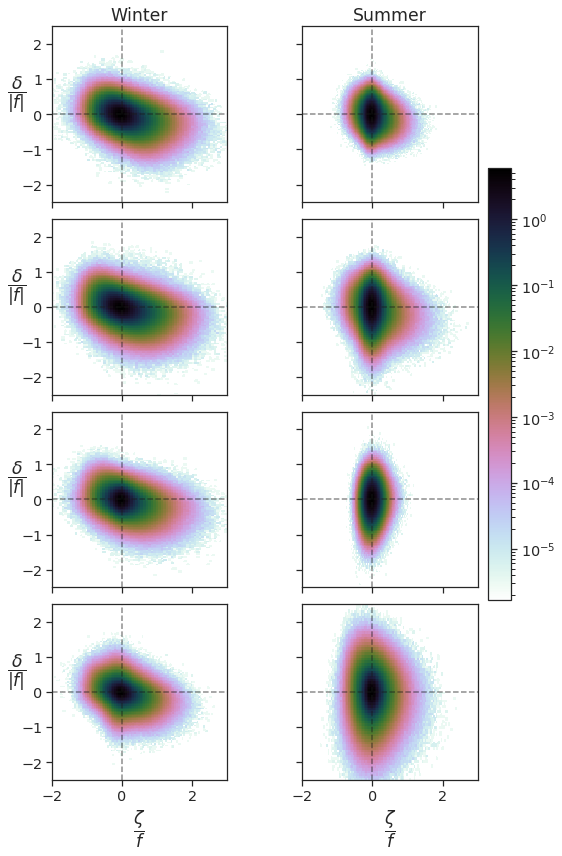

In [213]:
%matplotlib inline
plotjpdfs_sms()

9


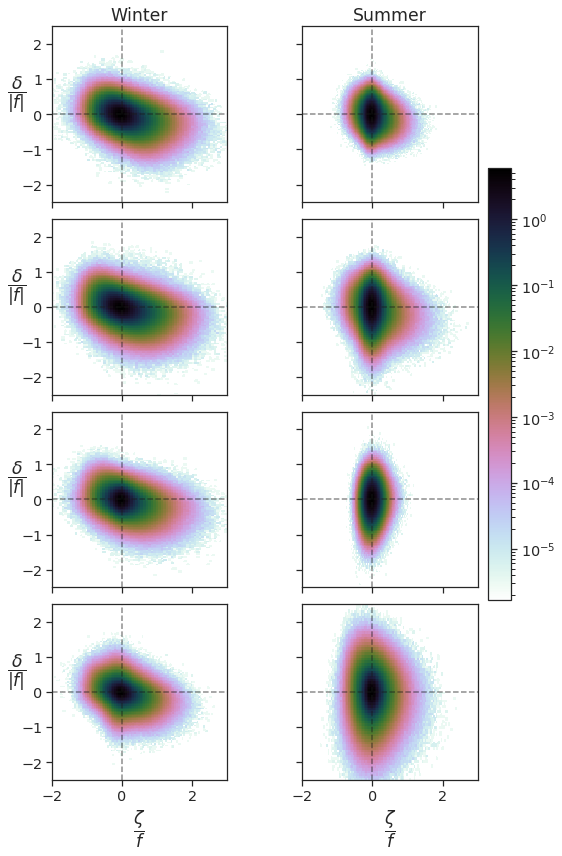

In [214]:
with open("{}/j_pdf/figure.pickle".format(LUIGI_OUT_FOLDER),"rb") as f_pkl:
    fig_ = pickle.load(f_pkl)
    ax = fig_.axes[:]
    print(len(ax))
    for ax_ in ax:
        pass
    plt.show()

In [25]:
curr4id = {762:"California", 750:"Canarias", 572:"Peru", 533:"Benguela"}

def plot_wk_kediv():
    fig, ax = plt.subplots(4, 3, figsize=(12,12), sharex="all", sharey="all", constrained_layout=True)
    for i,rid in enumerate([762,750,572,533]):
        seasons = ["JFM","ASO"] if i<2 else ["ASO","JFM"]
        for j,season in enumerate(seasons):
            ## Calculate filtered Ro and Delta
            ensure_spectra(rid,season)
            spectra_tmp = load_spectra(rid,season)
            Lt = spectra_tmp["Lt_km"]
            om = spectra_tmp["om"]
            ki = spectra_tmp["k_h"]
            KEi = spectra_tmp["KE"]
            RVi = spectra_tmp["KE_RV"]
            DIVi = spectra_tmp["KE_DIV"]
            RVDIV = RVi/DIVi
            minRVDIV = np.log10(np.min(RVDIV))
            maxRVDIV = np.log10(np.max(RVDIV))
            limExp = min(np.abs(minRVDIV),maxRVDIV)
            lims = (10**(-limExp),10**limExp)

            #
            plt.sca(ax[i,j])
            plt.pcolormesh(ki,om,(RVDIV).T,norm = colors.LogNorm(vmin=lims[0],vmax=lims[1],clip=True),cmap=plt.cm.BrBG)
            plt.xscale('log')
            plt.xticks(xticks,xticksLabel)
            plt.xlim(xlims)
            plt.yscale('log')
            plt.ylim([om[1],om[-100]])
            plt.yticks(yticks,yticksLabel)
            #plt.colorbar()
            plt.axvline(x=1/Lt,color='r')
            plt.xlabel(r'Horizontal scales [km]',size='xx-large')
            #plt.ylabel(curr4id[rid],size='x-large')
            plt.ylabel(r'Time scales',size='xx-large')#,rotation='horizontal')

            #ax[i,j].set_aspect('equal',adjustable="box", anchor="C", share=True)
            ax[i,j].tick_params(labelsize='x-large')

            if i==0:
                if j==0:
                    plt.title("Winter",size='xx-large')
                elif j==1:
                    plt.title("Summer",size='xx-large')

    # Remove unnecessary labels
    for ax_ in ax.flat:
        ax_.label_outer()

    fig.tight_layout()
    cax = plt.axes([1, 0.3, 0.04, 0.5])
    cb = plt.colorbar(cax=cax)
    cb.ax.tick_params(labelsize='x-large')
    #with open("{}/j_pdf/figure.pickle".format(LUIGI_OUT_FOLDER),"wb") as f_pkl:
    #	print("Dumping")
    #	pickle.dump(fig,f_pkl)
    print("Showing")
    plt.show()


Showing


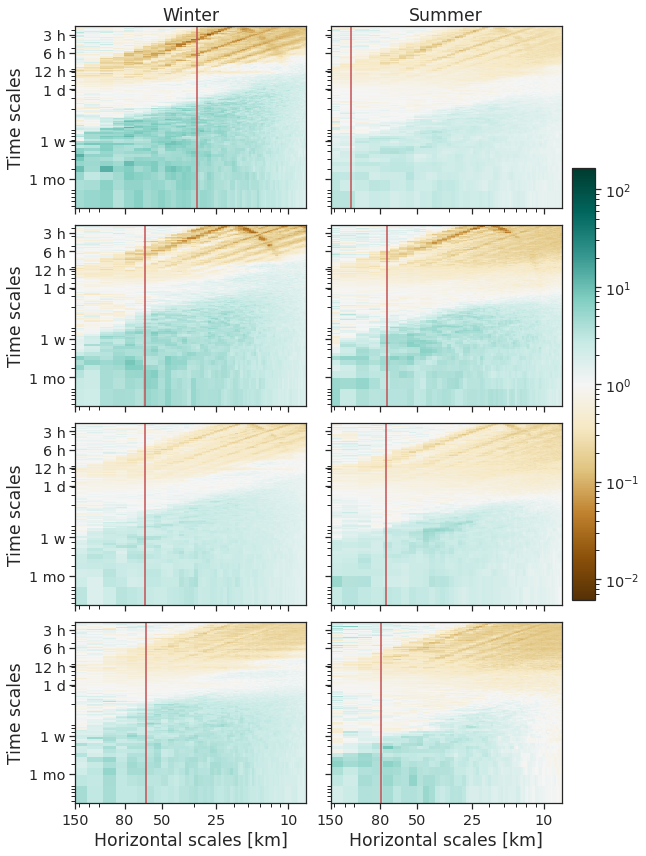

In [63]:
%matplotlib inline
plot_wk_kediv()

In [26]:
# https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/gradient_bar.html
def addColorBar(ax,y,extent=(0,1,0,1)):
    y = np.array(y)
    n = y.size
    #print(y)
    X = np.repeat(y,3).reshape(n,3).T
    #print(X)
    norm = DivergingNorm(vmin=-np.pi/2, vcenter=0, vmax=np.pi/2)
    ax.imshow(X, interpolation='bicubic', cmap=plt.cm.RdBu_r, norm=norm, alpha=0.15, extent=extent, transform=ax.transAxes)


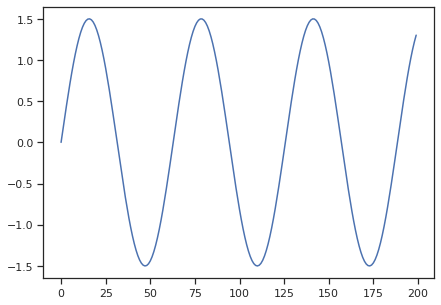

In [27]:
## Test: AddColorBar
N = 200
x = np.arange(N)
y = 1.5*np.sin(x/10)

plt.figure(figsize=(7,5))
plt.plot(x,y)


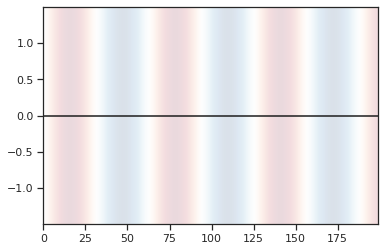

In [28]:
x0,x1 = x.min(),x.max()
y0,y1 = y.min(),y.max()
ax = plt.gca()
ax.set(xlim=(x0,x1),ylim=(y0,y1))
addColorBar(ax,y)
plt.axhline(y=0,c='k')
ax.set_aspect('auto')
plt.show()

In [29]:
import matplotlib.dates as mdates

def plot_stats(current, t_idx_slice=slice(0,None), centerLine=None):
    # Vars 
    scales = ["lo","hi"]
    scaleTitle = ["Mesoscale","Submesoscale"]
    # Time slice
    # Main loop
    for rid in ids_regions[current][-1:]:
        #grid = VorticityGrid(rid)
        lat = lats4id[rid]
        lon = lons4id[rid]
        for season in ["ASO","JFM"]:
            season_ext = "{}_ext".format(season)
            # Season time slice
            time_hr = idx_t["hours"][season_ext][t_idx_slice]
            time_sim = [simulationTime(hr) for hr in time_hr]
            tMin = time_sim[0]
            tMax = time_sim[-1]
            logging.info("{} ({}): {}, ({} to {})".format(rid,current,season_ext,tMin,tMax))
            ## Loading Lt info and calculating sun angle
            ensure_spectra(rid,season)
            spectra_tmp = load_spectra(rid,season)
            Lt = spectra_tmp["Lt_km"]
            sunAngle_ = [sunAngle(lon,lat,t_) for t_ in time_hr]
            logging.info("{} ({}): {}, Lt = {}".format(rid,current,season_ext,Lt))

            ## Loading stats
            stats = ensure_load_stats(rid,season_ext,Lt,t_idx_slice)

            ## X axis: time
            # Major ticks every 6 months.
            fmt_month = mdates.MonthLocator(interval=1)
            # Minor ticks every month.
            fmt_week = mdates.AutoDateLocator()

            ## Plot limits
            # HF
            minHf = np.nanmin(stats["hflux_mean_min"][t_idx_slice])
            maxHf = np.nanmax(stats["hflux_mean_max"][t_idx_slice])
            minTau = np.nanmin(stats["tauabs_mean"][t_idx_slice])
            maxTau = np.nanmax(stats["tauabs_mean"][t_idx_slice])
            minT = np.nanmin(stats["theta_mean_min"][t_idx_slice])
            maxT = np.nanmax(stats["theta_mean_max"][t_idx_slice])
            # Wind stress
            min_abstau = np.nanmin(stats["tauabs_mean"][t_idx_slice])
            max_abstau = np.nanmax(stats["tauabs_mean"][t_idx_slice])
            # HBL
            min_hbl = np.nanmin(stats["hbl_mean"][t_idx_slice])
            max_hbl = np.nanmax(stats["hbl_mean"][t_idx_slice])

            with sns.axes_style("whitegrid"):
                ## HF - Plot
                fig, ax = plt.subplots(3,1,figsize=(20,20))

                plt.sca(ax[0])
                ax[0].set(xlim=(tMin,tMax), ylim=(minTau,maxTau), autoscale_on=False)
                line1, = ax[0].plot(time_sim,stats["tauabs_mean"][t_idx_slice],c='b',label='avg(|Tau|)')
                plt.axhline(y=0,ls='--',c='k',alpha=0.5)
                if(centerLine is not None):
                    center_hr = idx_t["hours"][season_ext][centerLine]
                    plt.axvline(x=simulationTime(center_hr),ls='--',c='r',alpha=0.5)
                    plt.axvline(x=simulationTime(center_hr+12),ls='--',c='b',alpha=0.5)
                addColorBar(ax[0],sunAngle_)
                ax2 = ax[0].twinx()
                ax[0].tick_params(axis='y', colors='blue')
                ax2.tick_params(axis='y', colors='red')
                line2, = ax2.plot(time_sim,stats["hbl_mean"][t_idx_slice],c='r',label="KPPhbl")
                ax2.grid(b=False,axis='both')
                plt.legend((line1,line2),("avg(|Tau|)","KPPhbl"),loc="upper right")
                ax[0].xaxis.set_major_locator(fmt_month)
                ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
                ax[0].xaxis.set_minor_locator(fmt_week)
                ax[0].xaxis.set_minor_formatter(mdates.DateFormatter('%b-%d'))
                ax[0].set_aspect('auto')
                plt.title('Average wind intensity and average KPPhbl')

                plt.sca(ax[1])
                ax[1].set(xlim=(tMin,tMax), ylim=(minT,maxT), autoscale_on=False)
                line1, = ax[1].plot(time_sim,stats["theta_mean"][t_idx_slice],c='b',label='T')
                plt.axhline(y=0,ls='--',c='k',alpha=0.5)
                if(centerLine is not None):
                    center_hr = idx_t["hours"][season_ext][centerLine]
                    plt.axvline(x=simulationTime(center_hr),ls='--',c='r',alpha=0.5)
                    plt.axvline(x=simulationTime(center_hr+12),ls='--',c='b',alpha=0.5)
                # dTh = np.gradient(stats["theta_mean"][t_idx_slice])
                axDT = ax[1].twinx()
                ax[1].tick_params(axis='y', colors='blue')
                axDT.tick_params(axis='y', colors='red')
                line2, = axDT.plot(time_sim,stats["hflux_mean"][t_idx_slice],c='r',label='oceQnet')
                axDT.grid(b=False,axis='both')
                addColorBar(ax[1],sunAngle_)
                plt.legend((line1,line2),('T','oceQnet'),loc="upper right")
                ax[1].xaxis.set_major_locator(fmt_month)
                ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
                ax[1].xaxis.set_minor_locator(fmt_week)
                ax[1].xaxis.set_minor_formatter(mdates.DateFormatter('%b-%d'))
                ax[1].set_aspect('auto')
                plt.title("Temperature and oceQnet")

                ## Std - Plot
                #fig, ax = plt.subplots(1,2,figsize=(15,6))
                stdRo = [stats["ro{}_std".format(scale)][t_idx_slice] for scale in scales]
                stdDel = [stats["del{}_std".format(scale)][t_idx_slice] for scale in scales]

                for i in range(1):
                    i = i+2
                    ax_ = ax[i]
                    minY = np.nanmin(stats["ro{}_std".format(scales[1])][t_idx_slice])
                    maxY = np.nanmax(stats["ro{}_std".format(scales[1])][t_idx_slice])

                    ax_.set(xlim=(tMin,tMax), ylim=(minY,maxY), autoscale_on=False)
                    # Sun angle (w.r.t. horizon) -- red=positive, blue=negative
                    addColorBar(ax_,sunAngle_)
                    # Std
                    plt.sca(ax_)
                    line1, = plt.plot(time_sim,stdRo[1],c='xkcd:pinkish',label="$\zeta/f$")
                    if(centerLine is not None):
                        center_hr = idx_t["hours"][season_ext][centerLine]
                        plt.axvline(x=simulationTime(center_hr),ls='--',c='r',alpha=0.5)
                        plt.axvline(x=simulationTime(center_hr+12),ls='--',c='b',alpha=0.5)
                    ax2_ = ax_.twinx()
                    ax_.tick_params(axis='y', colors='xkcd:pinkish')
                    ax2_.tick_params(axis='y', colors='xkcd:olive green')
                    line2, = ax2_.plot(time_sim,stdDel[1],c='xkcd:olive green',label="$\delta/f$")
                    ax2_.grid(b=False,axis='both')
                    plt.legend((line1,line2),("$\zeta/f$","$\delta/f$"))
                    ax[0].xaxis.set_major_locator(fmt_month)
                    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
                    ax[0].xaxis.set_minor_locator(fmt_week)
                    ax[0].xaxis.set_minor_formatter(mdates.DateFormatter('%b-%d'))
                    ax_.set_aspect('auto')
                    plt.title("{} relative vorticity and divergence (RMS)".format(scaleTitle[1]))
                ax[-1].set_xlabel("Time",size='xx-large')
                plt.show()

            nfft = 6
            f_ticklabels = [2,4,6,12,24,36,48,72,24*7,nfft]
            #f_ticklabels = [6,12,24,36,48,72,24*4,24*7]
            f_ticks = [1/tk for tk in f_ticklabels]

            #with sns.axes_style("whitegrid"):
            #    fig, ax = plt.subplots(4,1,figsize=(10,20))

            #    #CSD
            #    plt.sca(ax[0])
            #    csd_zd, fcsd = plt.csd(stdRo[1], stdDel[1], nfft ,1.)
                #fcsd, csd_zd = signal.csd(stdRo[1], stdDel[1], 1., detrend='linear', window='hamm')
                #plt.stem(fcsd,np.abs(csd_zd))
            #    ax[0].set_xscale('log')
            #    plt.xticks(ticks=f_ticks, labels=f_ticklabels)
            #    plt.ylabel("Cross spectral density")

                #Coherence
            #    plt.sca(ax[1])
            #    czd, fcoh = plt.cohere(stdRo[1], stdDel[1], nfft, 1.)
            #    ax[1].set_xscale('log')
            #    plt.xticks(ticks=f_ticks, labels=f_ticklabels)
                #fcoh, czd = signal.coherence(stdRo[1], stdDel[1], 1., detrend='linear', window='hamm')
            #    coh_zd = czd
            #    ci = 0.9
            #    edof = (stats["length"]/(nfft/2)) * coh_zd.mean()
            #    gamma = 1.-(1-ci)**(1./(edof-1.)) # Conf interval
            #    conf = np.where(coh_zd>gamma)
            #    plt.ylabel("Coherence >{0}% interval ({1:.2f})".format(100*ci,gamma))

                #Phase (degrees)
             #   plt.sca(ax[2])
             #   angle_zd = np.angle(csd_zd)*180/np.pi
             #   plt.plot(fcoh[conf], angle_zd[conf],'ro')
             #   ax[2].set_xscale('log')
             #   plt.xticks(ticks=f_ticks, labels=f_ticklabels)
             #   plt.ylim([-185,185])
             #   ax[2].set_yticklabels([-180,-135,-90,-45,0,45,90,135,180])
              #  plt.ylabel("Phase difference (degrees)")

           #     plt.sca(ax[3])
           #     phdiff_hr = angle_zd/(fcoh*360.0)
           #     plt.plot(fcoh[conf], phdiff_hr[conf], 'ro')
           #     ax[3].set_xscale('log')
           #     plt.xticks(ticks=f_ticks, labels=f_ticklabels)
           #     plt.ylabel("Phase difference (hours)")
           #     plt.xlabel("Hours")

                #plt.show()

            #    print(1/fcoh[conf])
            #    print(phdiff_hr[conf])


2021-04-07 19:55:39 INFO     762 (California): ASO_ext, (2012-08-01 00:00:00+00:00 to 2012-11-14 23:00:00+00:00)
2021-04-07 19:55:39 INFO     Spectra file exists. Skipping.
2021-04-07 19:55:39 INFO     762 (California): ASO_ext, Lt = 116.23
2021-04-07 19:55:39 INFO     762: ASO_ext -- Ensuring
2021-04-07 19:55:39 INFO     762: ASO_ext -- Filename /mnt/disks/LLC4320/Luigi/stats/762_ASO_ext_hours.npz
2021-04-07 19:55:39 INFO     762: ASO_ext -- Opening /mnt/disks/LLC4320/Luigi/stats/762_ASO_ext_hours.npz
2021-04-07 19:55:39 INFO     762: ASO_ext -- File exists for the same parameters, and time slice (7752,10295) at least includes what we need (7752,10295)
2021-04-07 19:55:39 INFO     762: ASO_ext -- Opening /mnt/disks/LLC4320/Luigi/stats/762_ASO_ext_hours.npz


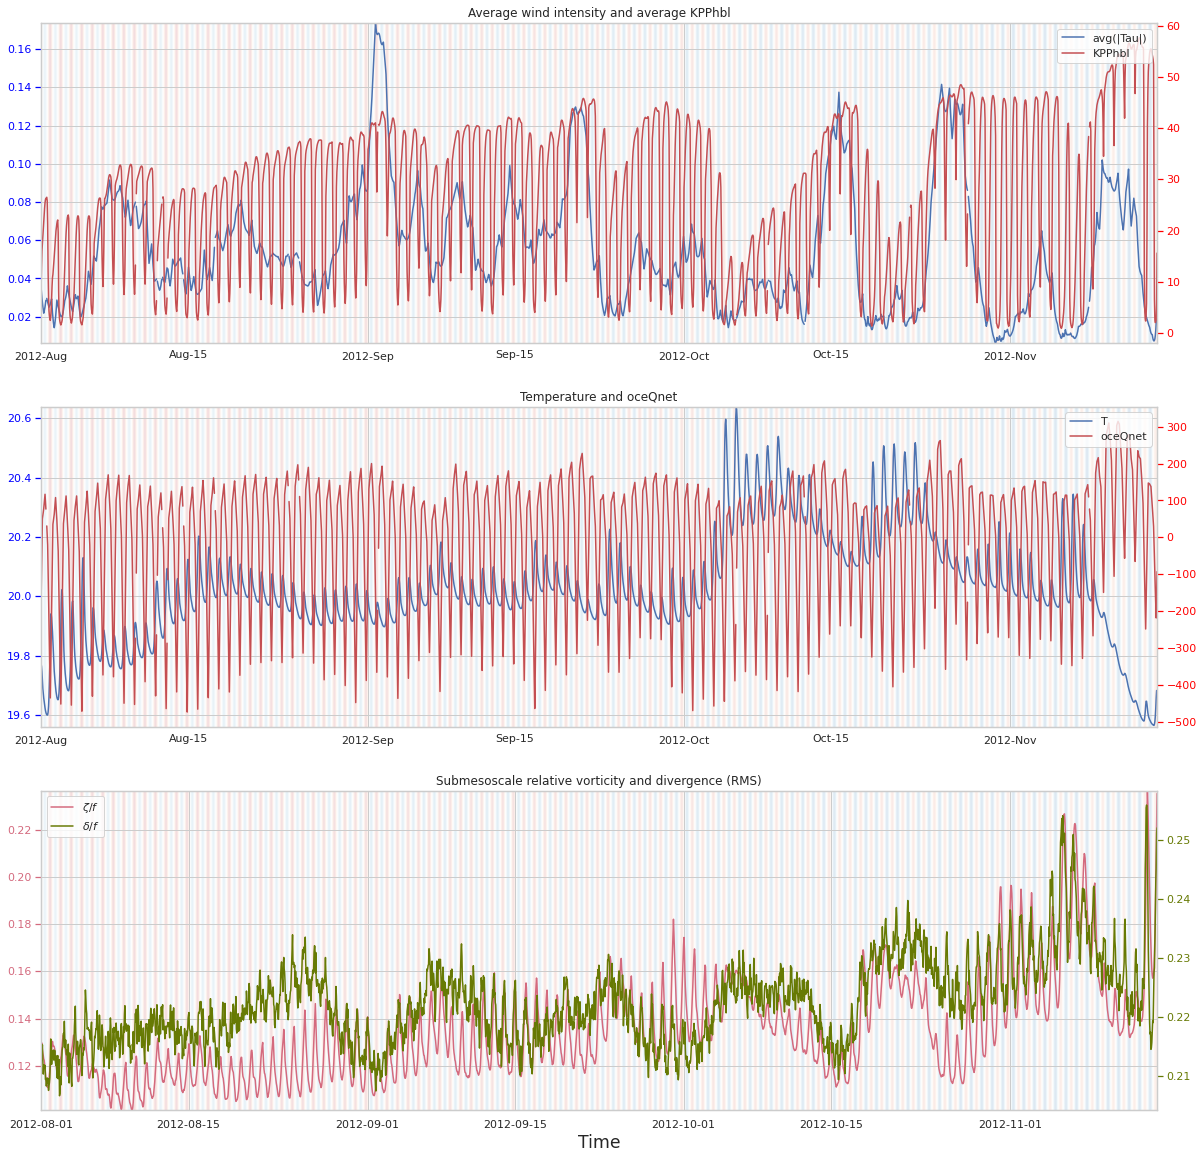

2021-04-07 19:55:42 INFO     762 (California): JFM_ext, (2012-01-01 00:00:00+00:00 to 2012-04-30 23:00:00+00:00)
2021-04-07 19:55:42 INFO     Spectra file exists. Skipping.
2021-04-07 19:55:42 INFO     762 (California): JFM_ext, Lt = 32.0
2021-04-07 19:55:42 INFO     762: JFM_ext -- Ensuring
2021-04-07 19:55:42 INFO     762: JFM_ext -- Filename /mnt/disks/LLC4320/Luigi/stats/762_JFM_ext_hours.npz
2021-04-07 19:55:42 INFO     762: JFM_ext -- Opening /mnt/disks/LLC4320/Luigi/stats/762_JFM_ext_hours.npz
2021-04-07 19:55:42 INFO     762: JFM_ext -- File exists for the same parameters, and time slice (2640,5543) at least includes what we need (2640,5543)
2021-04-07 19:55:42 INFO     762: JFM_ext -- Opening /mnt/disks/LLC4320/Luigi/stats/762_JFM_ext_hours.npz


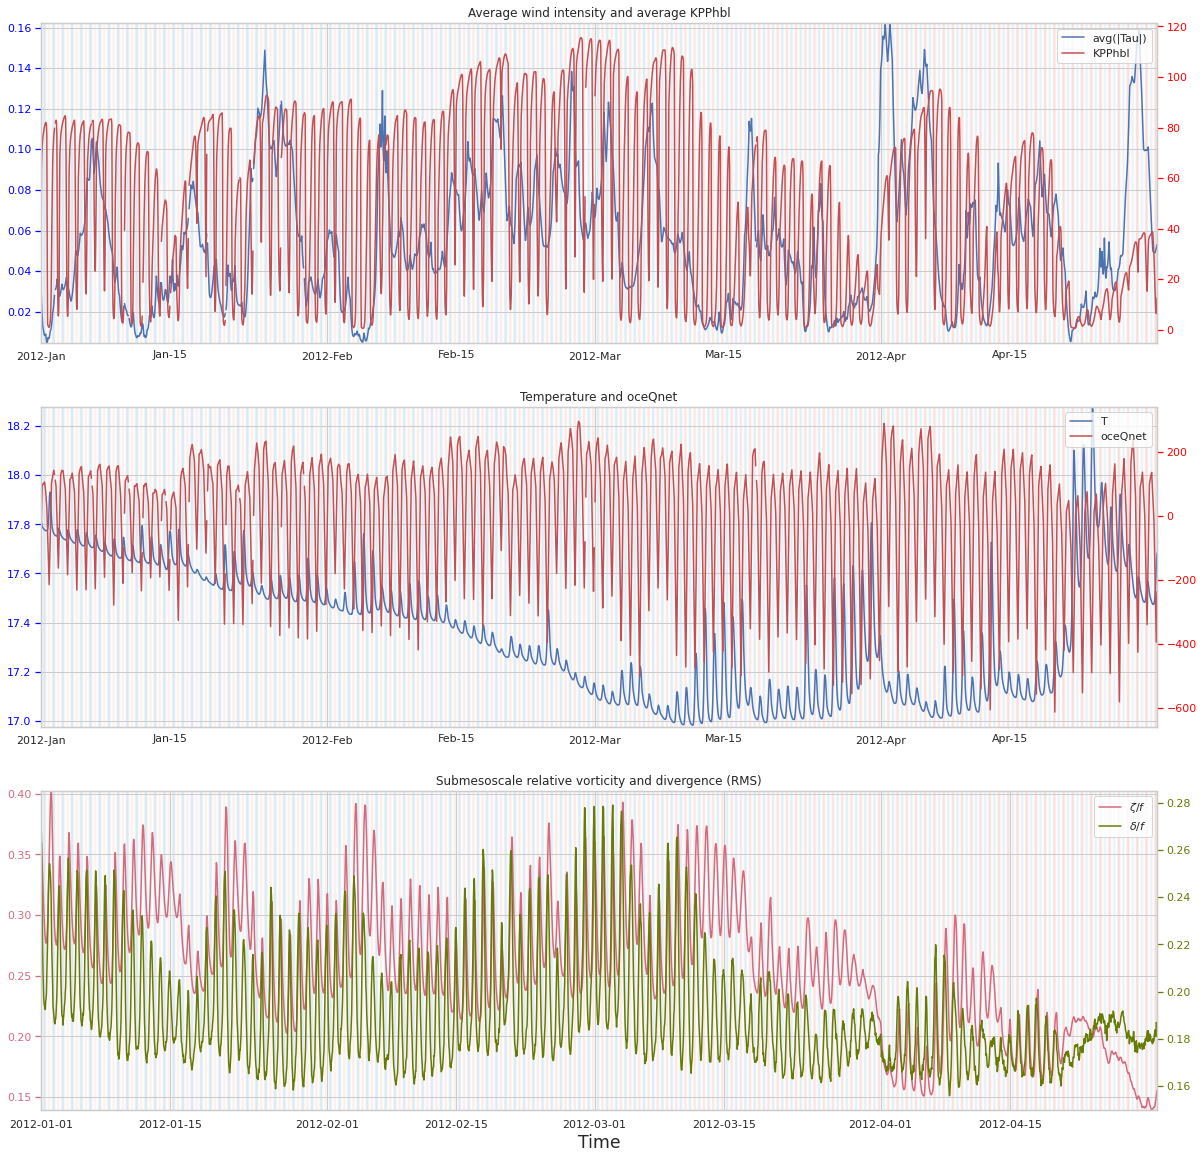

In [37]:
plot_stats("California")

2021-04-07 19:55:45 INFO     730 (Canarias): ASO_ext, (2012-08-01 00:00:00+00:00 to 2012-11-14 23:00:00+00:00)
2021-04-07 19:55:45 INFO     Spectra file exists. Skipping.
2021-04-07 19:55:45 INFO     730 (Canarias): ASO_ext, Lt = 77.7
2021-04-07 19:55:45 INFO     730: ASO_ext -- Ensuring
2021-04-07 19:55:45 INFO     730: ASO_ext -- Filename /mnt/disks/LLC4320/Luigi/stats/730_ASO_ext_hours.npz
2021-04-07 19:55:45 INFO     730: ASO_ext -- Opening /mnt/disks/LLC4320/Luigi/stats/730_ASO_ext_hours.npz
2021-04-07 19:55:45 INFO     730: ASO_ext -- File exists for the same parameters, and time slice (7752,10295) at least includes what we need (7752,10295)
2021-04-07 19:55:45 INFO     730: ASO_ext -- Opening /mnt/disks/LLC4320/Luigi/stats/730_ASO_ext_hours.npz


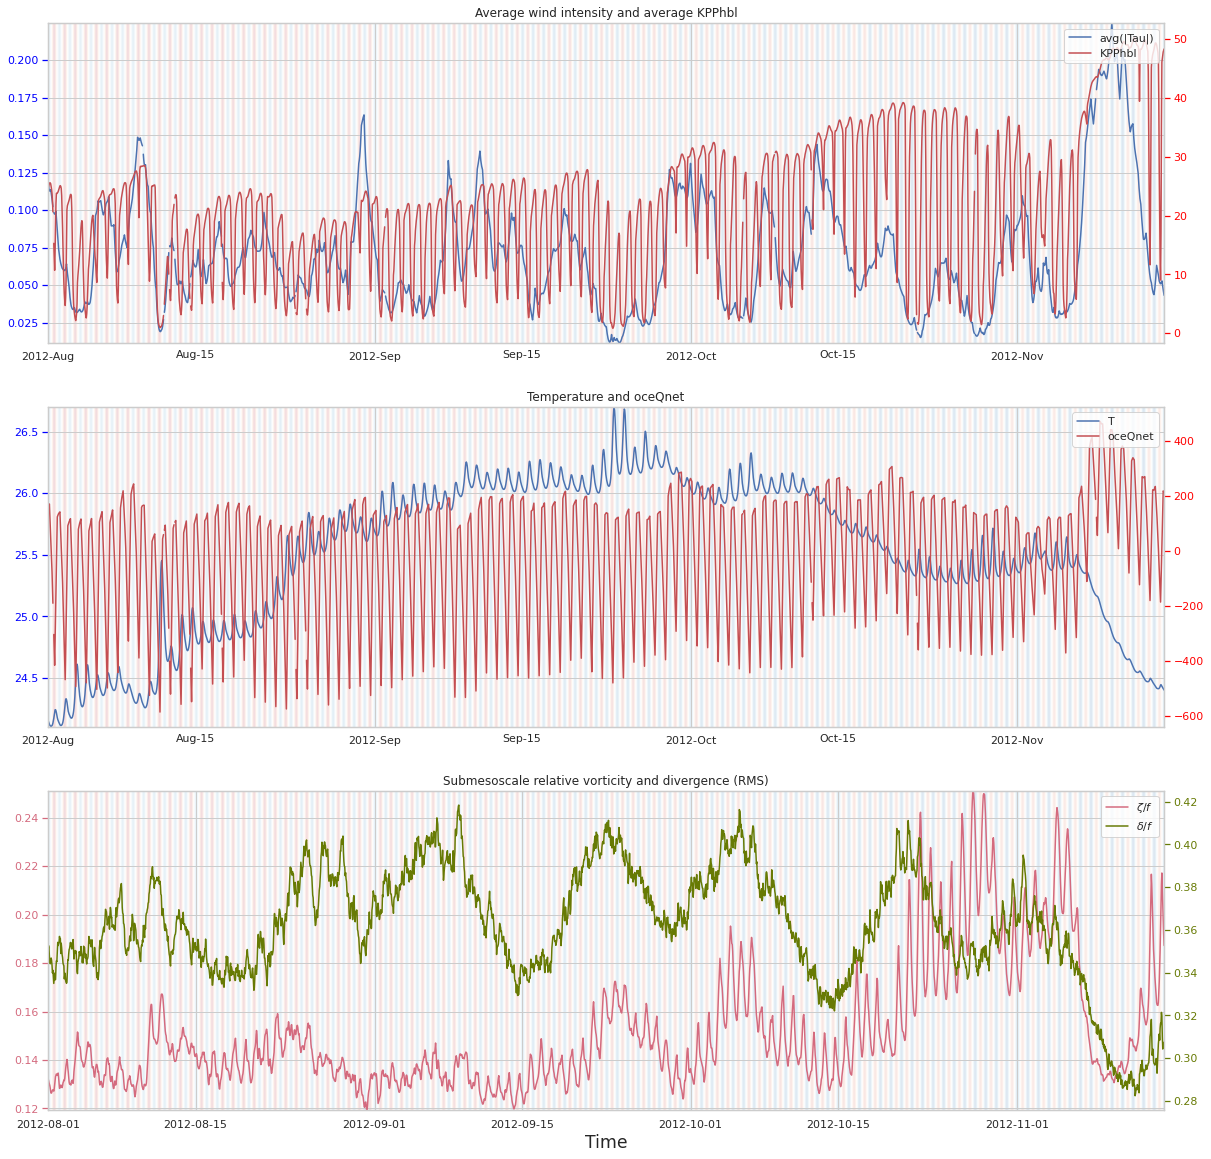

2021-04-07 19:55:48 INFO     730 (Canarias): JFM_ext, (2012-01-01 00:00:00+00:00 to 2012-04-30 23:00:00+00:00)
2021-04-07 19:55:48 INFO     Spectra file exists. Skipping.
2021-04-07 19:55:48 INFO     730 (Canarias): JFM_ext, Lt = 64.0
2021-04-07 19:55:48 INFO     730: JFM_ext -- Ensuring
2021-04-07 19:55:48 INFO     730: JFM_ext -- Filename /mnt/disks/LLC4320/Luigi/stats/730_JFM_ext_hours.npz
2021-04-07 19:55:48 INFO     730: JFM_ext -- No file found...
2021-04-07 19:55:48 INFO     730: JFM_ext, Lt=64.0, res=hours -- Getting data
2021-04-07 19:55:48 INFO     Time idx: (0 to None), time: (from: 2640, to:5543, length:2904)
2021-04-07 19:55:49 INFO     Grid: dx = 2.1525167858620695 km, dy = 1.9787329799999998 km, dt = 1 h
2021-04-07 19:55:49 INFO     Exists? 730: _JFM_ext -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/730_JFM_ext_hours.npz
2021-04-07 19:55:49 INFO     Spectra - Variables: []
2021-04-07 19:55:49 INFO     Loading U: shape (k=0): (290, 289, 2904)
2021-04-07 19:56:35 I

In [ ]:
plot_stats("Canarias")

In [ ]:
plot_stats("Peru")

In [ ]:
plot_stats("Benguela")

In [ ]:
nn=20

def plot_rvdiv_daynight(current, season, dayIdx=0, timezone=0):
  #rid = ids_regions[current][-2]
  for rid in ids_regions[current]:
    print(current,ids_regions[current],rid)
    grid = VorticityGrid(rid)
    # DAY
    idx_t_day = idx_t["hours"][season][dayIdx - timezone]
    region_day = LLCRegion(rid, [idx_t_day], tag=season)
    time_sim_day = simulationTime(idx_t_day)
    print("Day", dayIdx - timezone, idx_t_day, time_sim_day)
    ujfm,vjfm = uv4idt(rid,idx_t_day,0)
    ro_day = grid.rv(ujfm,vjfm)/grid.f
    delta_day = grid.div(ujfm,vjfm)/grid.f
    # NIGHT
    nightIdx = dayIdx - timezone + 12
    idx_t_night = idx_t["hours"][season][nightIdx]
    region_night = LLCRegion(rid, [idx_t_night], tag=season)
    time_sim_night = simulationTime(idx_t_night)
    print("Night", nightIdx, idx_t_night, time_sim_night)
    # uaso,vaso = uv4idt(rid, idx_t_night, 0)
    # ro_night = grid.rv(uaso,vaso)/grid.f
    # delta_night = grid.div(uaso,vaso)/grid.f
    spectra_tmp = load_spectra(rid,season)
    Lt = spectra_tmp["Lt_km"]
    
    # RV and DIV filtered
    _,_,rohi_day,delhi_day = get_ro_delta(region_day, Lt)
    _,_,rohi_night,delhi_night = get_ro_delta(region_night, Lt)
    # Plot
    fig, ax = plt.subplots(5,2,figsize=(16,25))
    ax = ax.flat[:]
    plt.sca(ax[0])
    ro_day = rohi_day[0,:,:]
    plt.pcolormesh(grid.lon_g,grid.lat_g,ro_day,norm=divnorm_deltaro,cmap=cmocean.cm.curl)
    plt.title("RV: Noon @ {} ({}) - rms = {:0.3g}".format(rid,current, np.std(ro_day)))
    plt.colorbar()
    plt.sca(ax[1])
    ro_night = rohi_night[0,:,:]
    plt.pcolormesh(grid.lon_g,grid.lat_g,ro_night,norm=divnorm_deltaro,cmap=cmocean.cm.curl)
    plt.title("RV: Midnight @ {} ({}) - rms = {:0.3g}".format(rid,current, np.std(ro_night)))
    plt.colorbar()
    plt.sca(ax[2])
    delta_day = delhi_day[0,:,:]
    plt.pcolormesh(grid.lon_c,grid.lat_c,delta_day,norm=divnorm_deltaro,cmap=plt.cm.RdBu)
    plt.title("DIV: Noon @ {} ({}) - rms = {:0.3g}".format(rid,current, np.std(delta_day)))
    plt.colorbar()
    plt.sca(ax[3])
    delta_night = delhi_night[0,:,:]
    plt.pcolormesh(grid.lon_c,grid.lat_c,delta_night,norm=divnorm_deltaro,cmap=plt.cm.RdBu)
    plt.title("DIV: Midnight @ {} ({}) - rms = {:0.3g}".format(rid,current, np.std(delta_night)))
    plt.colorbar()
    # Theta
    theta_day = theta4idt(rid,idx_t_day,0)
    theta_night = theta4idt(rid,idx_t_night,0)
    min_theta = min(np.min(theta_day),np.min(theta_night))
    max_theta = max(np.max(theta_day),np.max(theta_night))
    norm_theta = Normalize(vmin=min_theta ,vmax=max_theta)
    plt.sca(ax[4])
    plt.pcolormesh(grid.lon_c,grid.lat_c,theta_day,norm=norm_theta,cmap=cmocean.cm.thermal)
    plt.title("SST: Day @ {} ({}) - mean = {:0.3g}".format(rid,current, np.mean(theta_day)))
    plt.colorbar()
    plt.sca(ax[5])
    plt.pcolormesh(grid.lon_c,grid.lat_c,theta_night,norm=norm_theta,cmap=cmocean.cm.thermal)
    plt.title("SST: Midnight @ {} ({}) - mean = {:0.3g}".format(rid,current, np.mean(theta_night)))
    plt.colorbar()
    # Wind
    taux_day,tauy_day = tau4idt(rid,idx_t_day,0)
    taux_night,tauy_night = tau4idt(rid,idx_t_night,0)
    taunorm_day = np.sqrt(taux_day**2 + tauy_day**2)
    taunorm_night = np.sqrt(taux_night**2 + tauy_night**2)
    min_tau = min(np.min(taunorm_day),np.min(taunorm_night))
    max_tau = max(np.max(taunorm_day),np.max(taunorm_night))
    norm_tau = Normalize(vmin=min_tau ,vmax=max_tau)
    plt.sca(ax[6])
    plt.quiver(grid.lon_c[::nn,::nn],grid.lat_c[::nn,::nn],taux_day[::nn,::nn]/max_tau,tauy_day[::nn,::nn]/max_tau,angles='xy',scale_units='xy',scale=3.,color='white',zorder=10,alpha=0.75)
    plt.pcolormesh(grid.lon_c,grid.lat_c,taunorm_day,norm=norm_tau,cmap=cmocean.cm.speed)
    plt.title("Wind stress: Day @ {} ({}) - mean = {:0.2g}".format(rid,current, np.mean(taunorm_day)))
    plt.colorbar()
    plt.sca(ax[7])
    plt.quiver(grid.lon_c[::nn,::nn],grid.lat_c[::nn,::nn],taux_night[::nn,::nn]/max_tau,tauy_night[::nn,::nn]/max_tau,angles='xy',scale_units='xy',scale=3.,color='white',zorder=10,alpha=0.75)
    plt.pcolormesh(grid.lon_c,grid.lat_c,taunorm_night,norm=norm_tau,cmap=cmocean.cm.speed)
    plt.title("Wind stress: Midnight @ {} ({}) - mean = {:0.2g}".format(rid,current, np.mean(taunorm_night)))
    plt.colorbar()
    # Joint PDF
    min_ro = min(np.min(ro_day),np.min(ro_night))
    max_ro = max(np.max(ro_day),np.max(ro_night))
    min_delta = min(np.min(delta_day),np.min(delta_night))
    max_delta = max(np.max(delta_day),np.max(delta_night))
    rolim = [min_ro,max_ro]
    deltalim = [min_delta,max_delta]
    plt.sca(ax[8])
    plt.hist2d(ro_day.flat[:],delta_night.flat[:],bins=100,density=True,norm=LogNorm(),cmap=plt.cm.cubehelix_r)
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    plt.axvline(x=0,ls='--',c='k',alpha=0.5)
    plt.axhline(y=0,ls='--',c='k',alpha=0.5)
    plt.xlabel("$RV/f$")
    plt.ylabel("$DIV/f$")
    plt.colorbar()
    plt.title("RV-DIV: Noon @ {} ({})".format(rid,current))
    plt.sca(ax[9])
    plt.hist2d(ro_night.flat[:],delta_night.flat[:],bins=100,density=True,norm=LogNorm(),cmap=plt.cm.cubehelix_r)
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    plt.axvline(x=0,ls='--',c='k',alpha=0.5)
    plt.axhline(y=0,ls='--',c='k',alpha=0.5)
    plt.xlabel("$RV/f$")
    plt.ylabel("$DIV/f$")
    plt.colorbar()
    plt.title("RV-DIV: Midnight @ {} ({})".format(rid,current))

    plt.show()

In [ ]:
snapshot_t = 24*64+12
tzone = - 8
curr_ = "California"
plot_rvdiv_daynight(curr_, "ASO", snapshot_t, tzone)
plot_rvdiv_daynight(curr_, "JFM", snapshot_t, tzone)
plot_stats(curr_, slice(snapshot_t-7*24-tzone, snapshot_t+7*24-tzone), snapshot_t-tzone)

In [ ]:
snapshot_t = 24*64+12
tzone = 0
curr_ = "Canarias"
plot_rvdiv_daynight(curr_, "ASO", snapshot_t, tzone)
plot_rvdiv_daynight(curr_, "JFM", snapshot_t, tzone)
plot_stats(curr_, slice(snapshot_t-7*24-tzone, snapshot_t+7*24-tzone), snapshot_t-tzone)

In [ ]:
snapshot_t = 24*64+12
tzone = -4
curr_ = "Peru"
plot_rvdiv_daynight(curr_, "ASO", snapshot_t, tzone)
plot_rvdiv_daynight(curr_, "JFM", snapshot_t, tzone)
plot_stats(curr_, slice(snapshot_t-7*24-tzone, snapshot_t+7*24-tzone), snapshot_t-tzone)

In [ ]:
snapshot_t = 24*64+12
tzone = 1
curr_ = "Benguela"
plot_rvdiv_daynight(curr_, "ASO", snapshot_t, tzone)
plot_rvdiv_daynight(curr_, "JFM", snapshot_t, tzone)
plot_stats(curr_, slice(snapshot_t-7*24-tzone, snapshot_t+7*24-tzone), snapshot_t-tzone)

In [121]:
LtWinter = [40.0,46.07,35.12,40.74,32.0,32.0,67.0,62.0,64.0,66.59,63.99,61.84,76.0,64.44,64.19,61.3]
LtSummer = [97.35,118.24,140.81,91.37,107.77,116.23,70.06,73.42,77.7,129.32,77.2,74.31,66.36,125.72,122.71,78.7]
Lats = [48.4,44.5,40.4,36.05,31.46,26.64,31.46,26.64,21.61,16.40,-16.39,-21.61,-40.41,-11.03,-16.39,-26.64]
Regions = [868,852,831,809,787,762,771,750,730,709,596,572,450,602,578,533]
Colors = ['g','g','g','g','g','g','r','r','r','r','k','k','k','c','c','c']

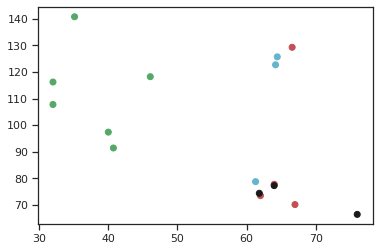

In [122]:
plt.figure()
plt.scatter(LtWinter,LtSummer,c=Colors)
plt.show()

In [60]:
def numbindecimals(n):
    (m,exponent) = frexp(n)
    decimals = 0
    while m>0:
        print(m)
        decimals+=1
        m,_ = modf(2*m)
    return decimals

In [68]:
numbindecimals(85.125)

0.6650390625
0.330078125
0.66015625
0.3203125
0.640625
0.28125
0.5625
0.125
0.25
0.5


10